In [1]:
! pwd

/cluster/home/taekim/stressed_mice/jupyter_notebooks


In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datetime import datetime

def run_random_forest_feature_selection_by_factor(input_file_path, output_dir=None, top_n=50):
    """
    Perform Random Forest feature selection analysis on genomic data, 
    with separate analyses for each factor of interest.
    
    Parameters:
    -----------
    input_file_path : str
        Path to the input CSV file with genomic data
    output_dir : str, optional
        Directory where output files will be saved. If None, uses the current directory.
    top_n : int, optional
        Number of top features to highlight in detailed analysis, default is 50
        
    Returns:
    --------
    results_dict : dict
        Dictionary containing results for each factor analysis
    importance_dict : dict
        Dictionary containing feature importance DataFrames for each factor
    """
    # Set default output directory if none provided
    if output_dir is None:
        output_dir = ''
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define a mapping from NCBI RefSeq accessions to UCSC chromosome names
    # Based on standard mouse genome mapping (assuming this is mouse data from the RefSeq IDs)
    chrom_dict = {
        'NC_000067.7': 'chr1',
        'NC_000067.8': 'chr1',
        'NC_000068.7': 'chr2',
        'NC_000068.8': 'chr2',
        'NC_000069.7': 'chr3',
        'NC_000069.8': 'chr3',
        'NC_000070.7': 'chr4',
        'NC_000070.8': 'chr4',
        'NC_000071.7': 'chr5',
        'NC_000071.8': 'chr5',
        'NC_000072.7': 'chr6',
        'NC_000072.8': 'chr6',
        'NC_000073.7': 'chr7',
        'NC_000073.8': 'chr7',
        'NC_000074.7': 'chr8',
        'NC_000074.8': 'chr8',
        'NC_000075.7': 'chr9',
        'NC_000075.8': 'chr9',
        'NC_000076.7': 'chr10',
        'NC_000076.8': 'chr10',
        'NC_000077.7': 'chr11',
        'NC_000077.8': 'chr11',
        'NC_000078.7': 'chr12',
        'NC_000078.8': 'chr12',
        'NC_000079.7': 'chr13',
        'NC_000079.8': 'chr13',
        'NC_000080.7': 'chr14',
        'NC_000080.8': 'chr14',
        'NC_000081.7': 'chr15',
        'NC_000081.8': 'chr15',
        'NC_000082.7': 'chr16',
        'NC_000082.8': 'chr16',
        'NC_000083.7': 'chr17',
        'NC_000083.8': 'chr17',
        'NC_000084.7': 'chr18',
        'NC_000084.8': 'chr18',
        'NC_000085.7': 'chr19',
        'NC_000085.8': 'chr19',
        'NC_000086.8': 'chrX',
        'NC_000086.9': 'chrX',
        'NC_000087.8': 'chrY',
        'NC_000087.9': 'chrY',
        'NC_005089.1': 'chrM'
    }
    
    # Function to parse bin_id and create new UCSC style ID
    def create_ucsc_style_id(bin_id):
        match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', bin_id)
        if match:
            index = float(match.group(1))
            strand = match.group(2)
            ref_seq = match.group(3)
            
            if ref_seq in chrom_dict:
                # Convert index to integer
                return f"{chrom_dict[ref_seq]}{strand}{int(index)}"
        return bin_id  # Return original if conversion fails

    # Read the data
    print(f"Reading data from {input_file_path}...")
    df = pd.read_csv(input_file_path)

    # Create feature IDs first
    df['FeatureID'] = df['Bin'].astype(str) + '_' + df['Strand'] + df['Chromosome'].astype(str)

    # Now convert these IDs to UCSC style
    df['UCSCFeatureID'] = df['FeatureID'].apply(create_ucsc_style_id)

    # Print some examples to verify the conversion
    print("\nExample UCSC Feature IDs:")
    for i, (orig, ucsc) in enumerate(zip(df['FeatureID'], df['UCSCFeatureID'])):
        if i < 5:  # Show first 5 examples
            print(f"  Original: {orig} → UCSC: {ucsc}")

    # Create pivot table with UCSC-style IDs
    pivot_df = df.pivot_table(index='Sample', 
                             columns='UCSCFeatureID', 
                             values='Median_Normalized_Damage',
                             aggfunc='mean')

    print(f"Data shape: {pivot_df.shape} (samples × features)")

    # Extract sample groups and components
    def extract_group_components(sample_name):
        match = re.search(r'(CRS|Ctrl)_(evening|morning)', sample_name)
        if match:
            treatment = match.group(1)  # CRS or Ctrl
            time = match.group(2)       # evening or morning
            full_group = match.group(0)  # e.g., "CRS_evening"
            return full_group, treatment, time
        else:
            return "Unknown", "Unknown", "Unknown"

    # Create target variables
    samples = pivot_df.index
    sample_info = [extract_group_components(sample) for sample in samples]
    full_groups = [info[0] for info in sample_info]
    treatments = [info[1] for info in sample_info]
    times = [info[2] for info in sample_info]

    # Print group distribution
    print("\nSample group distribution:")
    for group, count in zip(*np.unique(full_groups, return_counts=True)):
        print(f"  {group}: {count} samples")
    
    # Prepare feature data
    X = pivot_df.values
    X = np.nan_to_num(X, nan=0.0)  # Replace NaN with zero

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define the factors to analyze
    factor_analyses = {
        'full_groups': full_groups,               # All groups (CRS_evening, CRS_morning, Ctrl_evening, Ctrl_morning)
        'treatment': treatments,                  # CRS vs Ctrl (regardless of time)
        'time': times,                            # evening vs morning (regardless of treatment)
        'CRS_time': [t for i, t in enumerate(times) if treatments[i] == 'CRS'],  # Time effect within CRS
        'Ctrl_time': [t for i, t in enumerate(times) if treatments[i] == 'Ctrl'],  # Time effect within Ctrl
        'evening_treatment': [tr for i, tr in enumerate(treatments) if times[i] == 'evening'],  # Treatment effect in evening
        'morning_treatment': [tr for i, tr in enumerate(treatments) if times[i] == 'morning']   # Treatment effect in morning
    }
    
    # Filter indices for subset analyses
    CRS_indices = [i for i, tr in enumerate(treatments) if tr == 'CRS']
    Ctrl_indices = [i for i, tr in enumerate(treatments) if tr == 'Ctrl']
    evening_indices = [i for i, t in enumerate(times) if t == 'evening']
    morning_indices = [i for i, t in enumerate(times) if t == 'morning']
    
    factor_indices = {
        'full_groups': list(range(len(full_groups))),
        'treatment': list(range(len(treatments))),
        'time': list(range(len(times))),
        'CRS_time': CRS_indices,
        'Ctrl_time': Ctrl_indices,
        'evening_treatment': evening_indices,
        'morning_treatment': morning_indices
    }
    
    # Store results
    results_dict = {}
    importance_dict = {}
    
    # Run analysis for each factor
    for factor_name, factor_values in factor_analyses.items():
        print(f"\n{'='*50}")
        print(f"Analyzing factor: {factor_name}")
        
        # Get relevant indices for this analysis
        indices = factor_indices[factor_name]
        
        # Skip if not enough samples
        if len(indices) < 4:  # Need at least a few samples for meaningful analysis
            print(f"Skipping {factor_name} due to insufficient samples.")
            continue
            
        # Filter data
        X_factor = X_scaled[indices]
        y_factor = np.array(factor_values)
        
        # Skip if only one class
        unique_classes = np.unique(y_factor)
        if len(unique_classes) < 2:
            print(f"Skipping {factor_name} due to only one class: {unique_classes[0]}")
            continue
            
        print(f"Classes for {factor_name}: {unique_classes}")
        print(f"Class distribution: {[np.sum(y_factor == c) for c in unique_classes]}")
        
        # Encode labels
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y_factor)
        
        # Train Random Forest
        print(f"Training Random Forest for {factor_name}...")
        rf = RandomForestClassifier(n_estimators=500, random_state=42, 
                                   class_weight='balanced', n_jobs=20)
        rf.fit(X_factor, y_encoded)
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'Feature': pivot_df.columns,
            'Importance': rf.feature_importances_
        })
        importance_df = importance_df.sort_values('Importance', ascending=False)
        
        # Extract genomic information from UCSC-style IDs
        def extract_ucsc_info(ucsc_id):
            # Pattern to match UCSC style IDs like chr1+12345
            match = re.match(r'^(chr[^+-]+)([+-])(\d+)$', ucsc_id)
            if match:
                chrom = match.group(1)
                strand = match.group(2)
                position = int(match.group(3))
                return chrom, strand, position
            else:
                # For non-matching IDs, try to extract using original pattern
                match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', ucsc_id)
                if match:
                    bin_val = match.group(1)
                    strand = match.group(2)
                    chrom = match.group(3)
                    return chrom, strand, bin_val
                return "Unknown", "?", "Unknown"
        
        # Add genomic information to importance dataframe
        importance_df['Chromosome'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[0])
        importance_df['Strand'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[1])
        importance_df['Position'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[2])
        
        # Replace with this:
        # Add percentile and cumulative importance to ALL features
        importance_df['Percentile'] = importance_df['Importance'].rank(pct=True) * 100
        importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum() * 100

        # Save all features with enhanced information in one file
        all_features_file = os.path.join(output_dir, f'{factor_name}_all_features_importance.csv')
        importance_df.to_csv(all_features_file, index=False)
        print(f"Saved all features with importance metrics for {factor_name} to {all_features_file}")

        top_n_features = importance_df.head(top_n)
        
        # Print top 10 features
        print(f"Top 10 Features for {factor_name}:")
        for i, (feature, importance) in enumerate(zip(top_n_features['Feature'].head(10), 
                                                    top_n_features['Importance'].head(10))):
            print(f"  {i+1}. {feature}: {importance:.6f}")
        
        # Create a visualization
        plt.figure(figsize=(12, 10))
        plt.barh(np.arange(min(top_n, len(top_n_features))), 
                top_n_features['Importance'], align='center')
        plt.yticks(np.arange(min(top_n, len(top_n_features))), 
                  [f"{i+1}. {f}" for i, f in enumerate(top_n_features['Feature'])])
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Features for {factor_name}')
        plt.gca().invert_yaxis()  # Highest importance at the top
        plt.tight_layout()
        
        # Save plot
        top_n_plot_file = os.path.join(output_dir, f'{factor_name}_top_{top_n}_features_plot.png')
        plt.savefig(top_n_plot_file, dpi=300)
        print(f"Saved feature importance plot to {top_n_plot_file}")
        
        # Store results
        results_dict[factor_name] = {
            'classes': label_encoder.classes_,
            'top_features': top_n_features.head(10)['Feature'].tolist(),
            'n_samples': len(y_factor)
        }
        importance_dict[factor_name] = importance_df
    
    # Create a comparison plot for the top features across factors
    if len(importance_dict) > 1:
        print("\nCreating comparison of top features across factors...")
        
        # Get top 5 features from each factor
        top_features_by_factor = {}
        all_top_features = set()
        
        for factor, imp_df in importance_dict.items():
            top_features = imp_df.head(5)['Feature'].tolist()
            top_features_by_factor[factor] = top_features
            all_top_features.update(top_features)
        
        # Create comparison dataframe
        comparison_data = []
        for feature in all_top_features:
            row = {'Feature': feature}
            for factor, imp_df in importance_dict.items():
                feature_imp = imp_df.loc[imp_df['Feature'] == feature, 'Importance'].values
                row[factor] = feature_imp[0] if len(feature_imp) > 0 else 0
            comparison_data.append(row)
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('Feature')
        print(f"\nNumber of unique features in the comparison heatmap: {len(comparison_df)}")
        
        # Save comparison
        comparison_file = os.path.join(output_dir, 'top_features_comparison.csv')
        comparison_df.to_csv(comparison_file, index=False)
        print(f"Saved feature comparison to {comparison_file}")
        
        # Create heatmap visualization
        feature_cols = comparison_df.columns[1:]  # Skip 'Feature' column
        data_for_heatmap = comparison_df.set_index('Feature')[feature_cols]
        
        plt.figure(figsize=(14, len(all_top_features) * 0.5 + 3))
        sns.heatmap(data_for_heatmap, annot=True, cmap='viridis', fmt='.4f')
        plt.title('Feature Importance Comparison Across Factors')
        plt.tight_layout()
        
        # Save heatmap
        heatmap_file = os.path.join(output_dir, 'feature_importance_comparison_heatmap.png')
        plt.savefig(heatmap_file, dpi=300)
        print(f"Saved comparison heatmap to {heatmap_file}")
    
    return results_dict, importance_dict

# For cross-comparison of feature importance across factors
def feature_importance_comparison(importance_dict, output_dir=None, n_features=20):
    """
    Compare feature importance across different factors.
    
    Parameters:
    -----------
    importance_dict : dict
        Dictionary of feature importance DataFrames from run_random_forest_feature_selection_by_factor
    output_dir : str, optional
        Directory to save outputs
    n_features : int, optional
        Number of top features to include in the comparison
        
    Returns:
    --------
    comparison_df : pandas.DataFrame
        DataFrame with feature importance comparison
    """
    if output_dir is None:
        output_dir = ''
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Collect top features from all factors
    top_features = set()
    for factor, imp_df in importance_dict.items():
        top_features.update(imp_df.head(n_features)['Feature'].tolist())
    
    # Create comparison DataFrame
    comparison_data = []
    for feature in top_features:
        row = {'Feature': feature}
        # Get importance for this feature across all factors
        for factor, imp_df in importance_dict.items():
            match = imp_df[imp_df['Feature'] == feature]
            if not match.empty:
                row[f"{factor}_Importance"] = match['Importance'].values[0]
                row[f"{factor}_Rank"] = match.index[0] + 1  # Add 1 for 1-based indexing
            else:
                row[f"{factor}_Importance"] = 0
                row[f"{factor}_Rank"] = np.nan
        comparison_data.append(row)
    
    # Convert to DataFrame and sort
    comparison_df = pd.DataFrame(comparison_data)
    
    # Sort by maximum importance across all factors
    importance_cols = [col for col in comparison_df.columns if col.endswith('_Importance')]
    comparison_df['Max_Importance'] = comparison_df[importance_cols].max(axis=1)
    comparison_df = comparison_df.sort_values('Max_Importance', ascending=False)
    
    # Save comparison
    comparison_file = os.path.join(output_dir, f'top_{n_features}_features_cross_factor_comparison.csv')
    comparison_df.to_csv(comparison_file, index=False)
    print(f"Saved cross-factor feature comparison to {comparison_file}")
    
    # Create visualization - focusing on top 20 features by maximum importance
    viz_df = comparison_df.head(20).copy()
    
    # Reshape for better visualization
    factor_names = [col.replace('_Importance', '') for col in importance_cols]
    viz_data = []
    
    for _, row in viz_df.iterrows():
        feature = row['Feature']
        for factor in factor_names:
            viz_data.append({
                'Feature': feature,
                'Factor': factor,
                'Importance': row[f"{factor}_Importance"]
            })
    
    viz_df_long = pd.DataFrame(viz_data)
    
    # Create heatmap
    pivot_for_heat = viz_df_long.pivot(index='Feature', columns='Factor', values='Importance')
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot_for_heat, annot=True, cmap='viridis', fmt='.4f')
    plt.title(f'Feature Importance Comparison Across Factors (Top {len(pivot_for_heat)} Features)')
    plt.tight_layout()
    
    # Save heatmap
    heatmap_file = os.path.join(output_dir, f'top_{len(pivot_for_heat)}_features_importance_heatmap.png')
    plt.savefig(heatmap_file, dpi=300)
    print(f"Saved importance heatmap to {heatmap_file}")
    
    return comparison_df

# Example usage:
# results_dict, importance_dict = run_random_forest_feature_selection_by_factor('genomic_data.csv', 'output_dir')
# feature_importance_comparison(importance_dict, 'output_dir')

Reading data from ../data_normalized/cleaned_Normalized_100000.csv...

Example UCSC Feature IDs:
  Original: 3000000.0_+NC_000067.7 → UCSC: chr1+3000000
  Original: 3000000.0_-NC_000067.7 → UCSC: chr1-3000000
  Original: 3100000.0_+NC_000067.7 → UCSC: chr1+3100000
  Original: 3100000.0_-NC_000067.7 → UCSC: chr1-3100000
  Original: 3200000.0_+NC_000067.7 → UCSC: chr1+3200000
Data shape: (20, 53168) (samples × features)

Sample group distribution:
  CRS_evening: 5 samples
  CRS_morning: 5 samples
  Ctrl_evening: 5 samples
  Ctrl_morning: 5 samples

Analyzing factor: full_groups
Classes for full_groups: ['CRS_evening' 'CRS_morning' 'Ctrl_evening' 'Ctrl_morning']
Class distribution: [5, 5, 5, 5]
Training Random Forest for full_groups...
Saved all features with importance metrics for full_groups to ../data_rf/bin100000/full_groups_all_features_importance.csv
Top 10 Features for full_groups:
  1. chr7-17400000: 0.002816
  2. chr8-10200000: 0.002796
  3. chrX+43500000: 0.002639
  4. chr1+1497

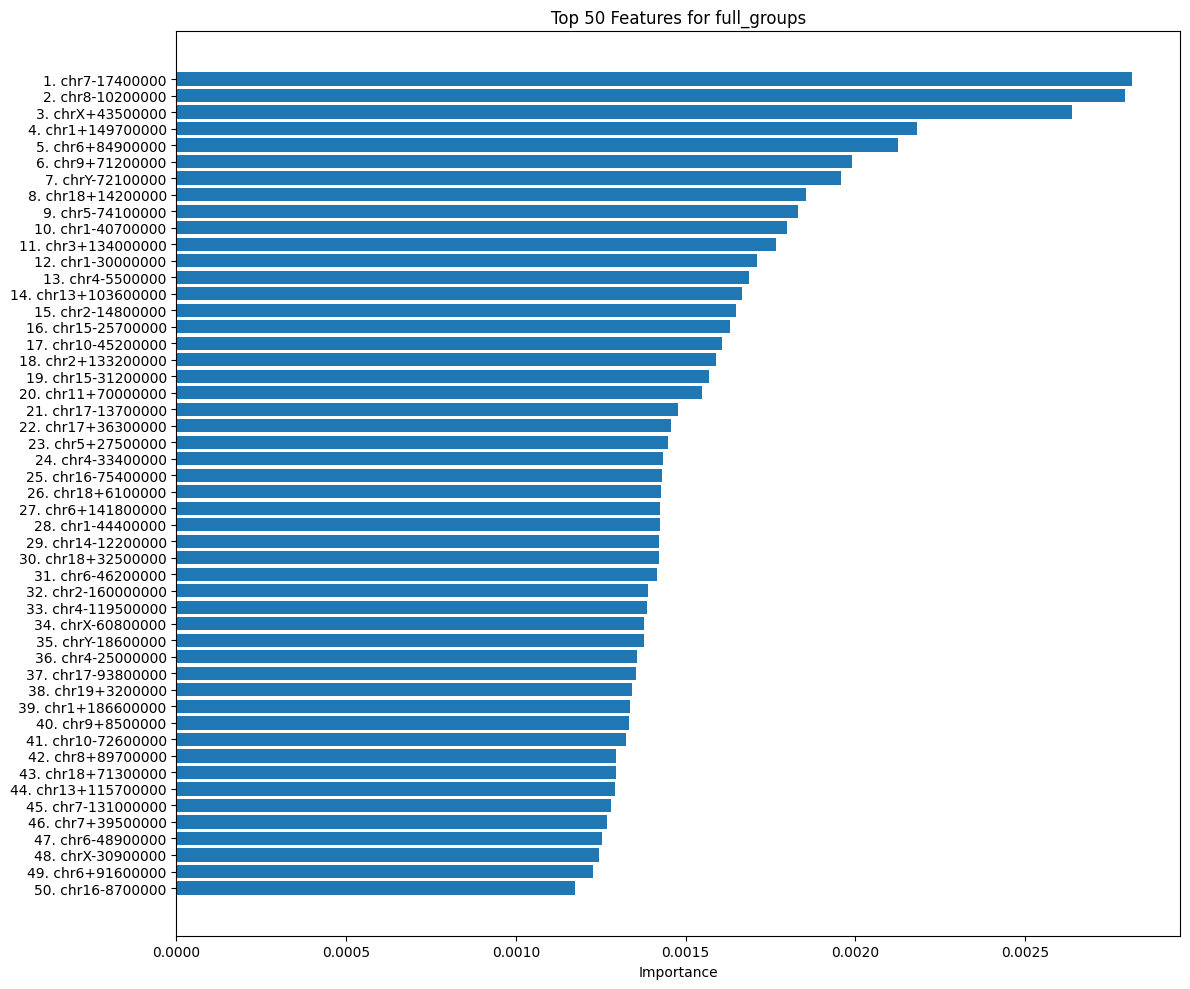

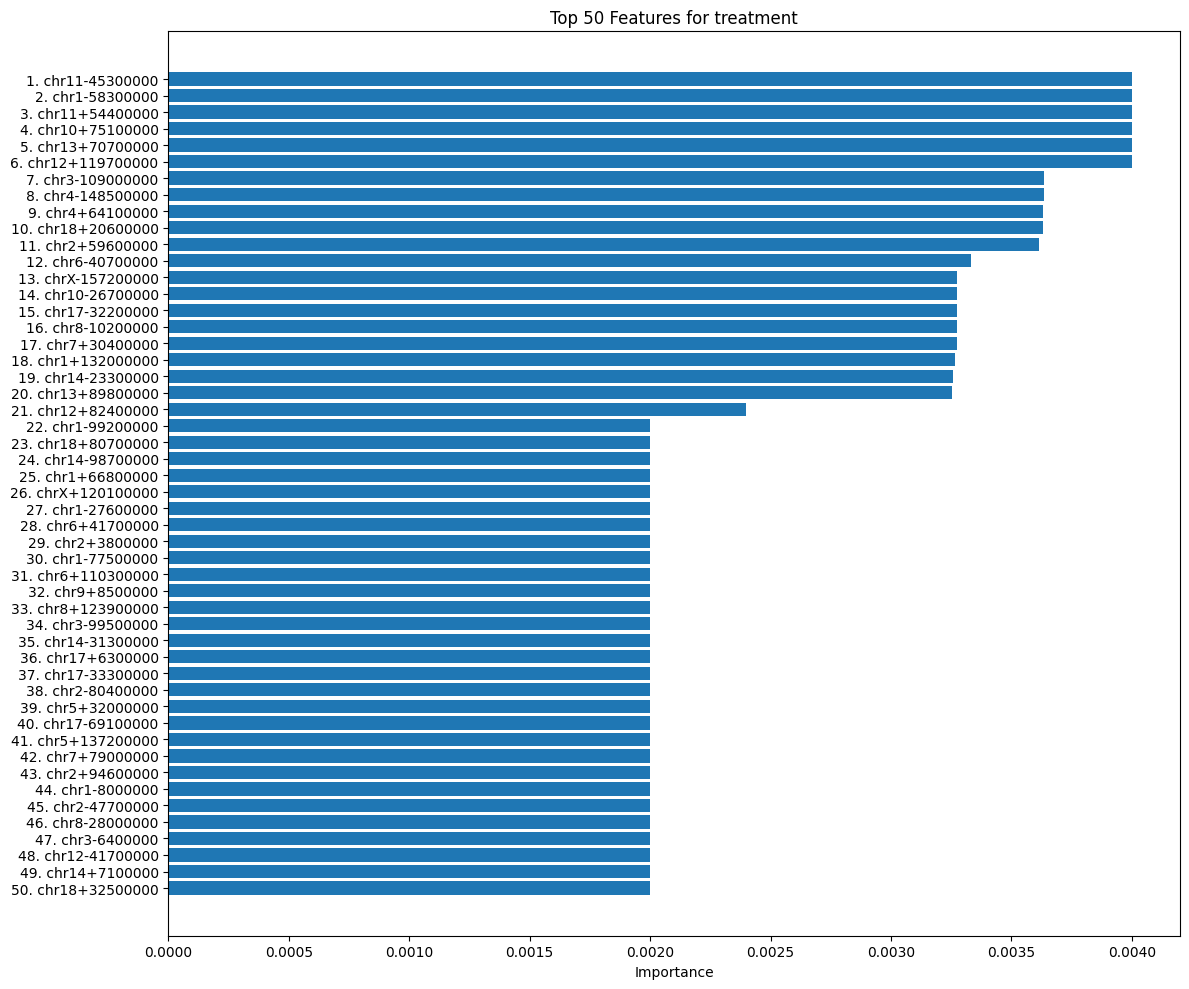

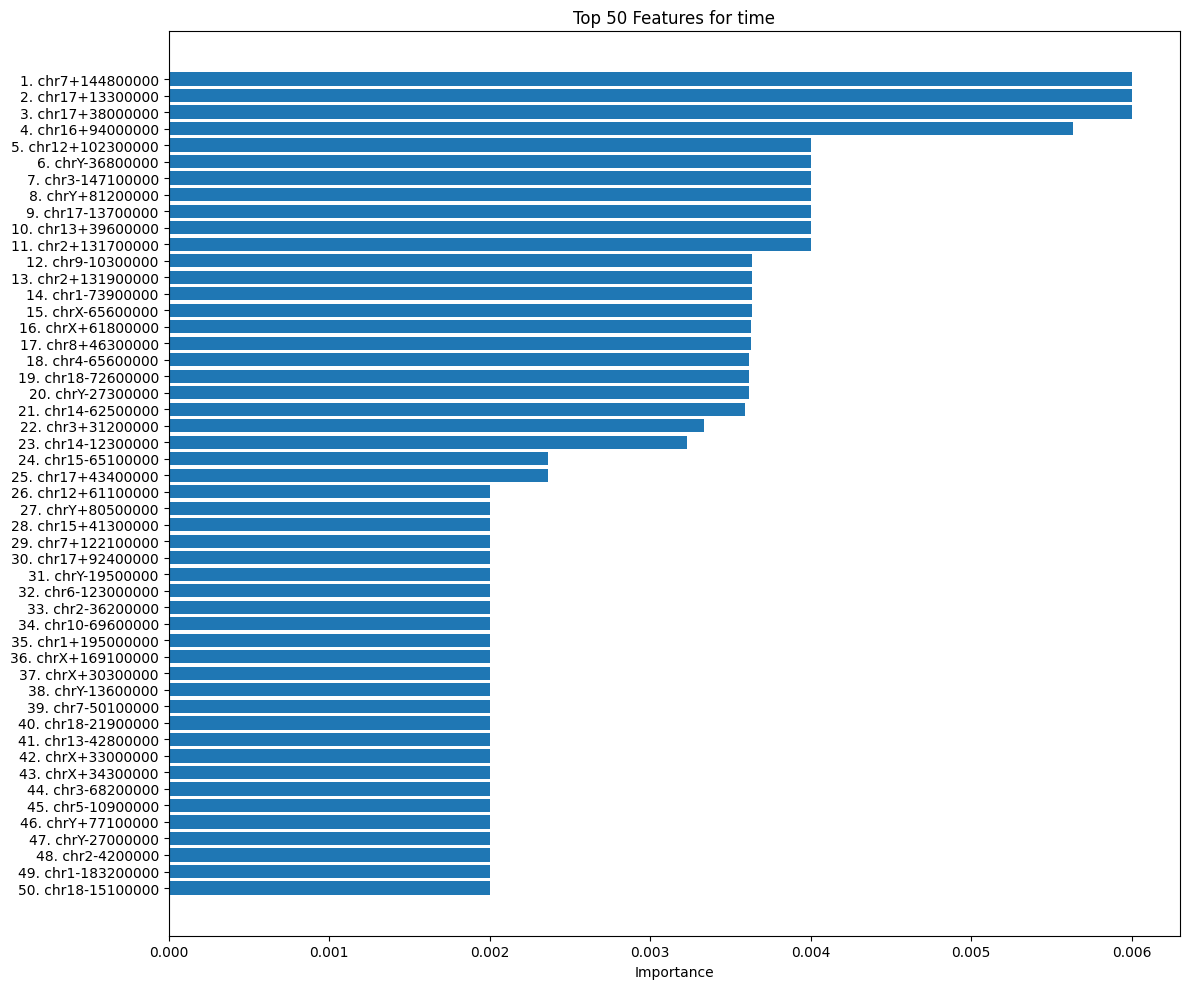

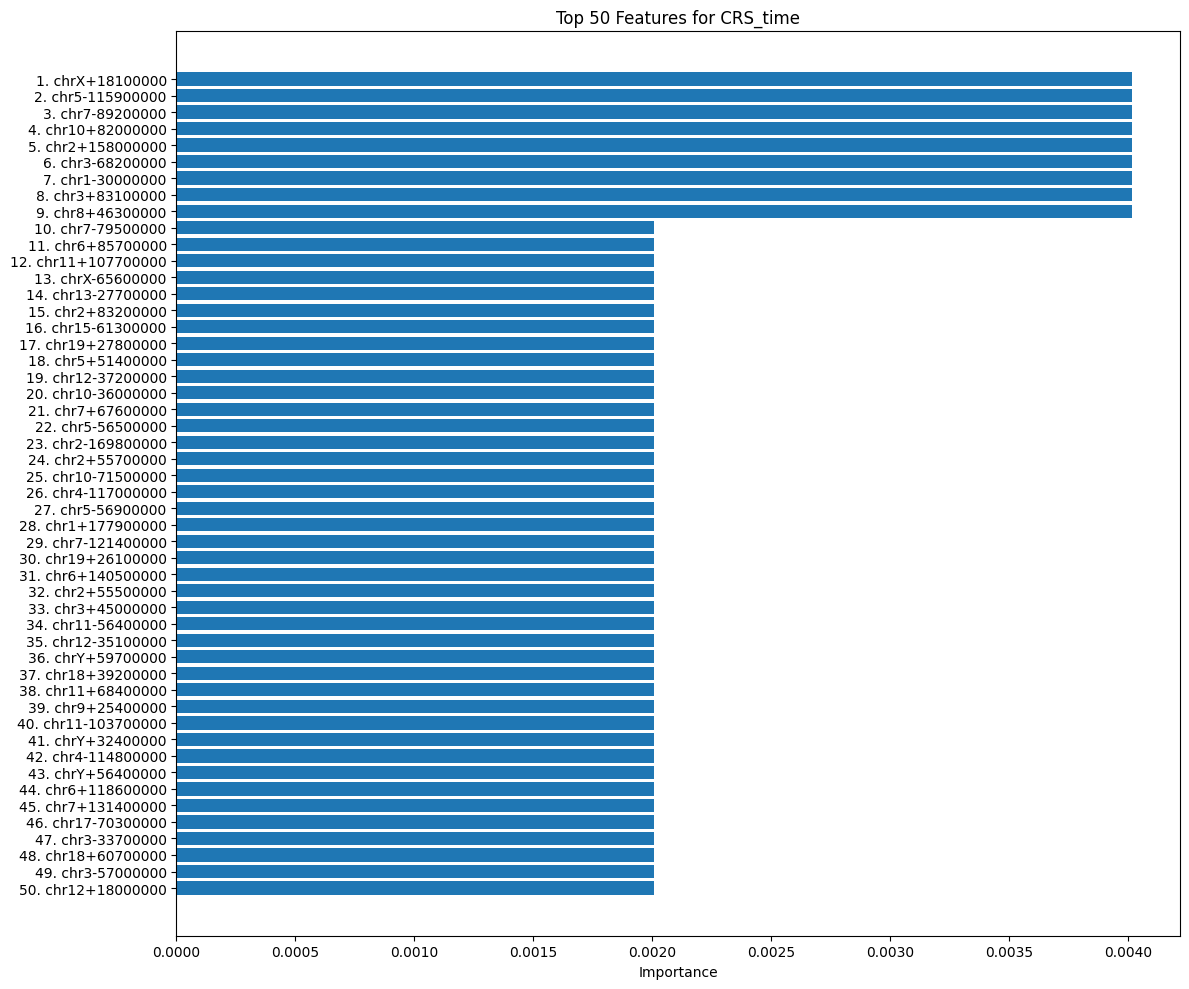

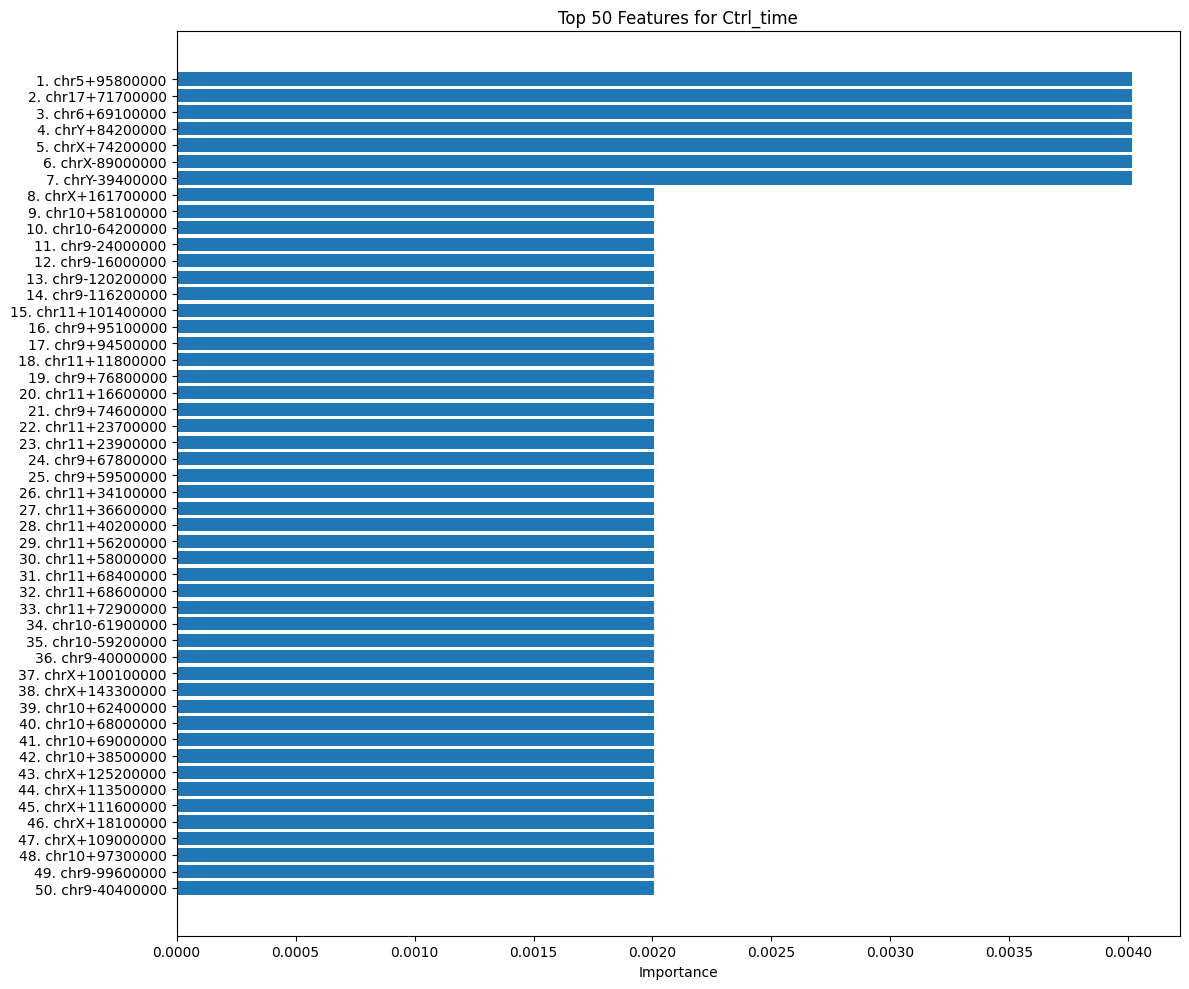

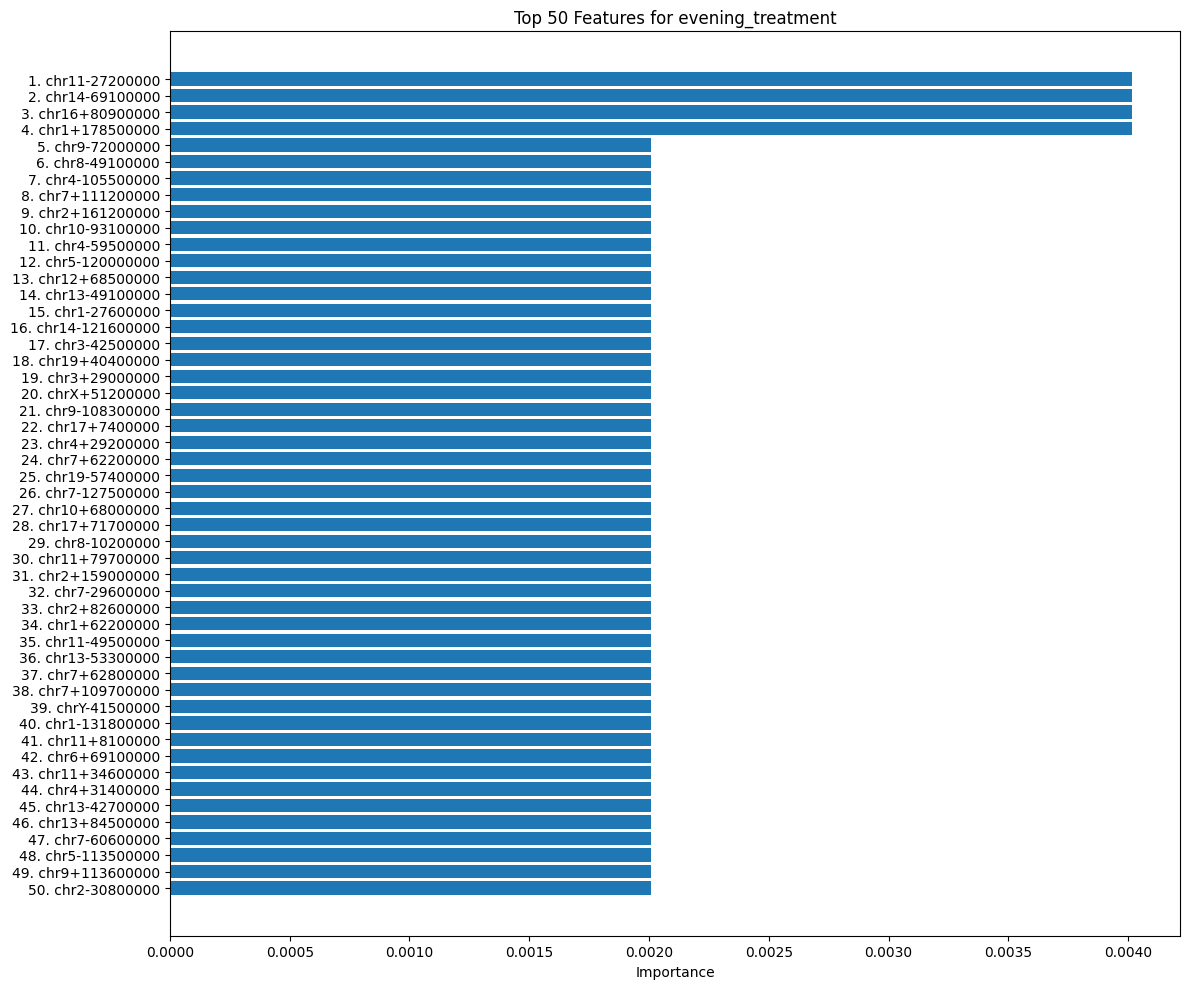

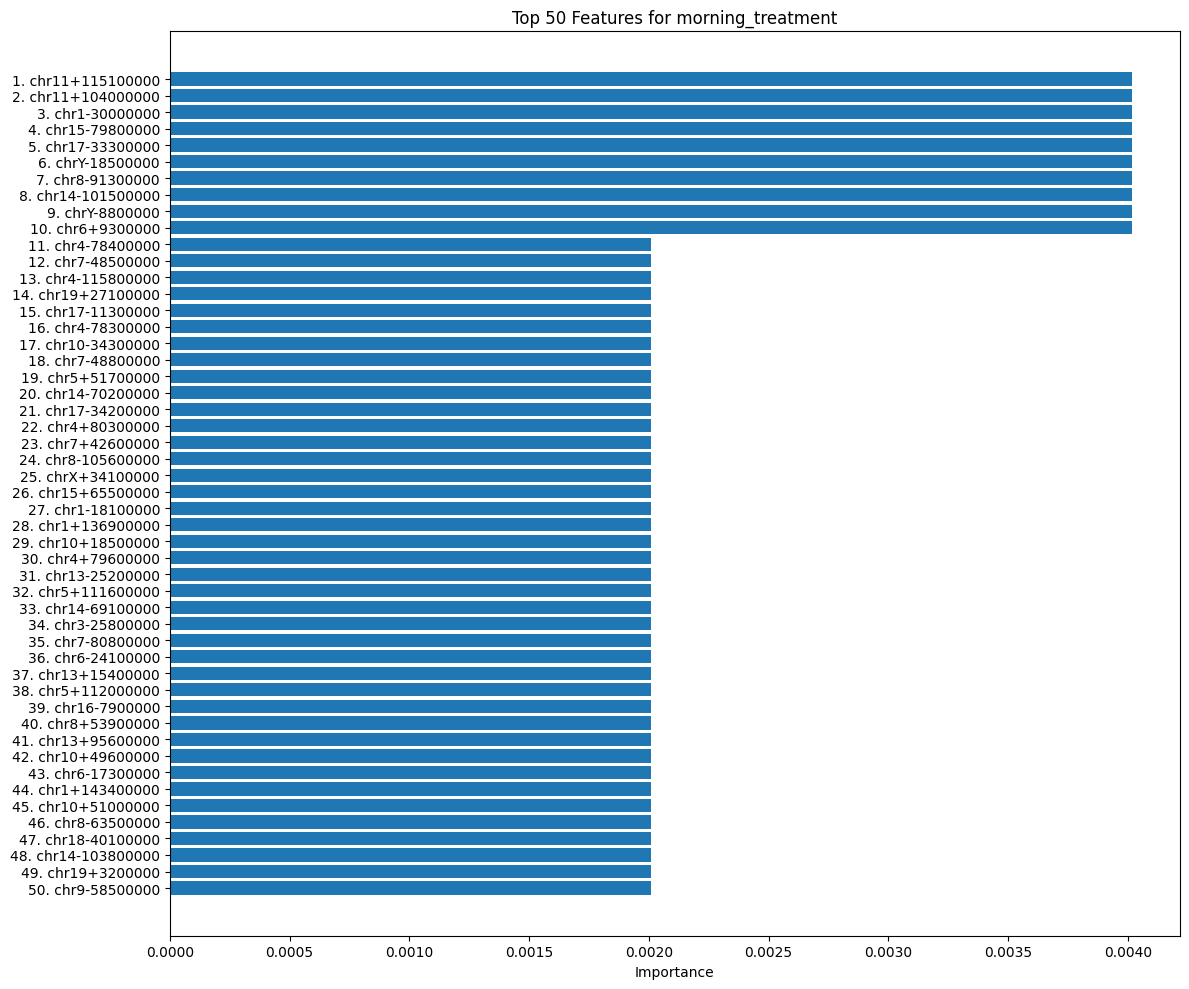

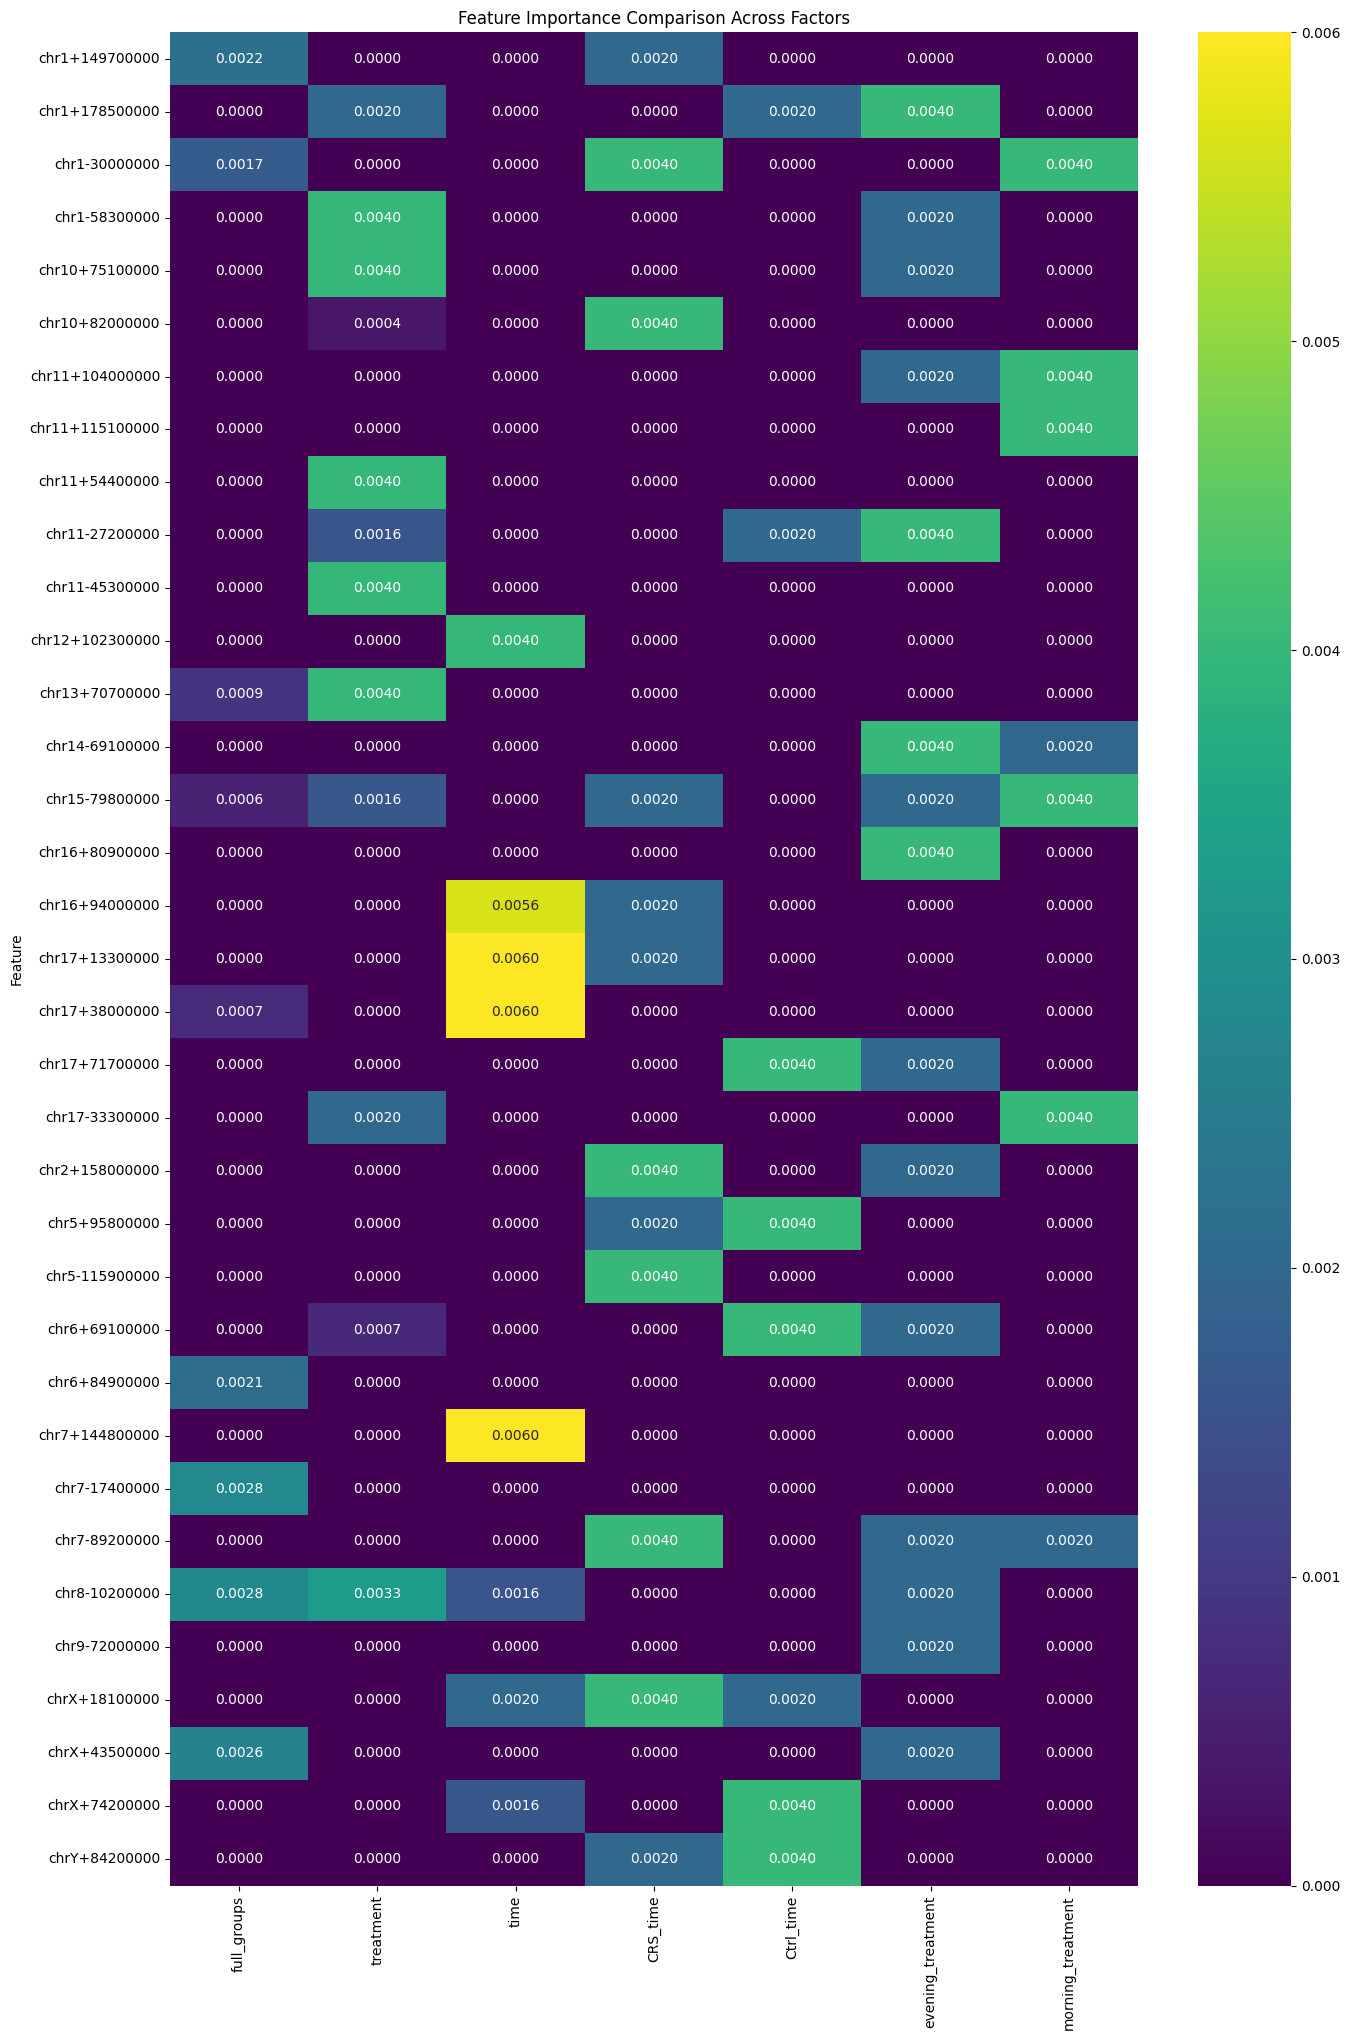

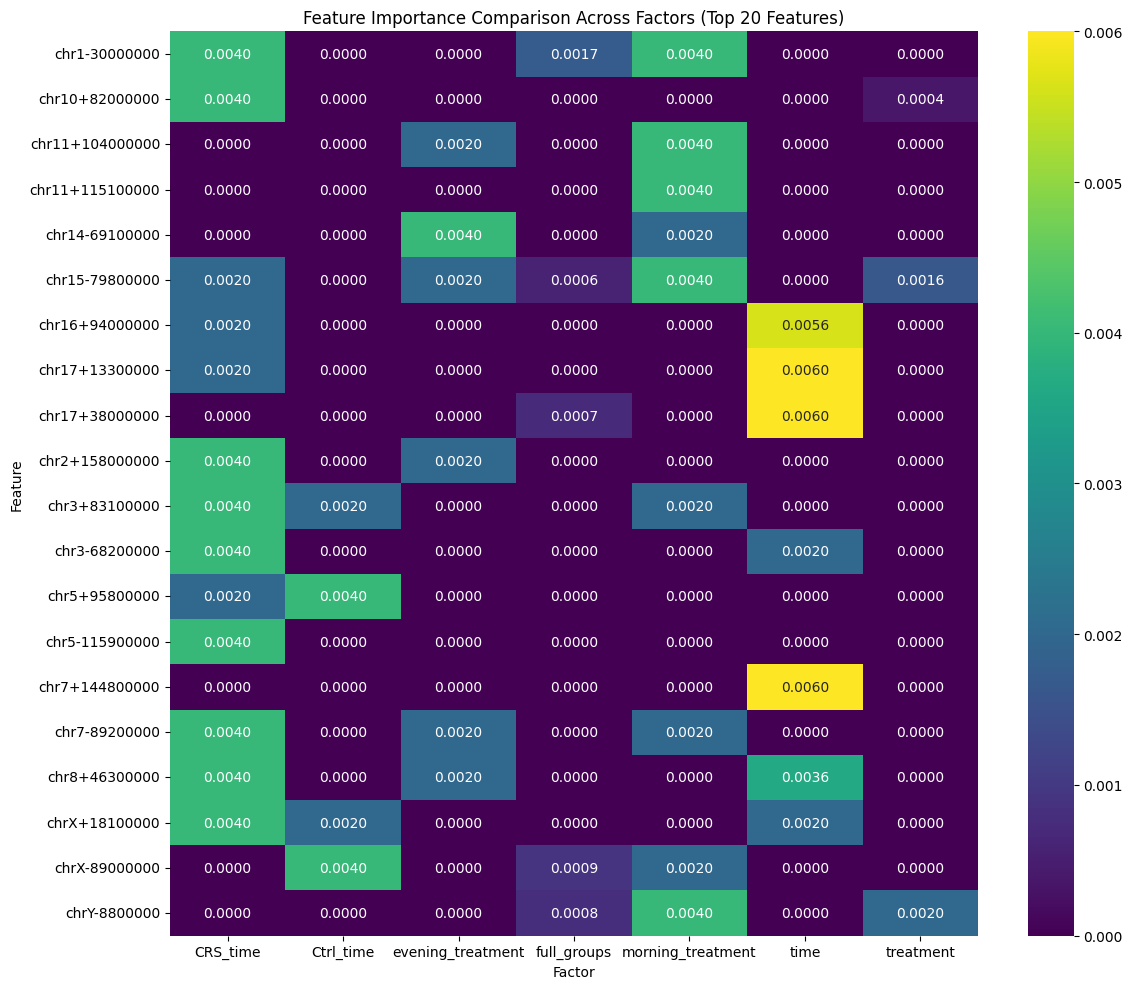

In [13]:
# Run the enhanced analysis
results_dict, importance_dict = run_random_forest_feature_selection_by_factor(
    '../data_normalized/cleaned_Normalized_100000.csv', 
    '../data_rf/bin100000'
)

# Optionally run the additional cross-factor comparison
comparison_df = feature_importance_comparison(
    importance_dict, 
    '../data_rf/bin100000'
)

Reading data from ../data_normalized/cleaned_Normalized_10000.csv...

Example UCSC Feature IDs:
  Original: 3040000.0_-NC_000067.7 → UCSC: chr1-3040000
  Original: 3050000.0_+NC_000067.7 → UCSC: chr1+3050000
  Original: 3050000.0_-NC_000067.7 → UCSC: chr1-3050000
  Original: 3060000.0_+NC_000067.7 → UCSC: chr1+3060000
  Original: 3060000.0_-NC_000067.7 → UCSC: chr1-3060000
Data shape: (20, 530255) (samples × features)

Sample group distribution:
  CRS_evening: 5 samples
  CRS_morning: 5 samples
  Ctrl_evening: 5 samples
  Ctrl_morning: 5 samples

Analyzing factor: full_groups
Classes for full_groups: ['CRS_evening' 'CRS_morning' 'Ctrl_evening' 'Ctrl_morning']
Class distribution: [5, 5, 5, 5]
Training Random Forest for full_groups...
Saved all features with importance metrics for full_groups to ../data_rf/bin10000/full_groups_all_features_importance.csv
Top 10 Features for full_groups:
  1. chr16+41560000: 0.001660
  2. chr4-15710000: 0.001524
  3. chr7+53350000: 0.001415
  4. chr12-587

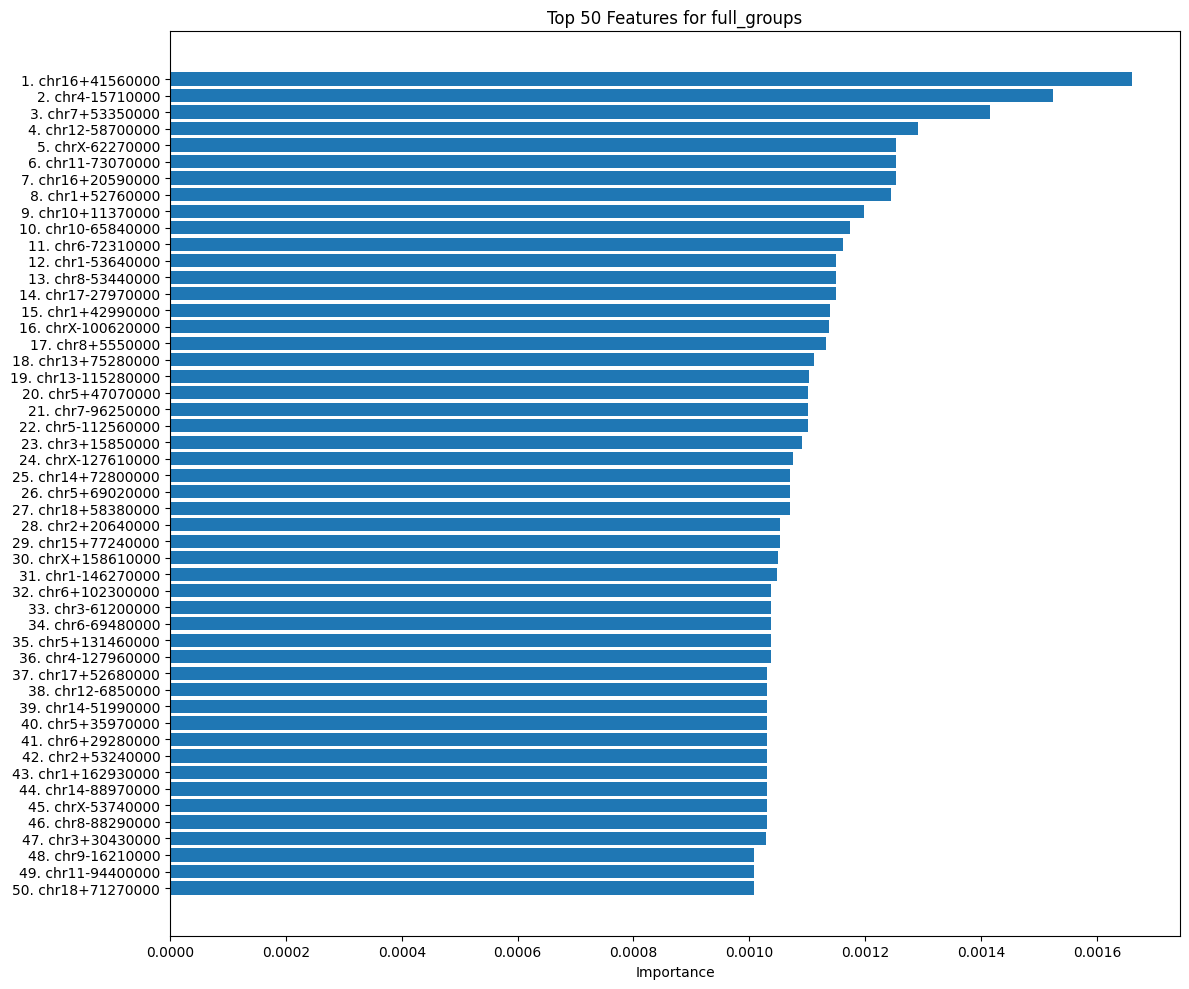

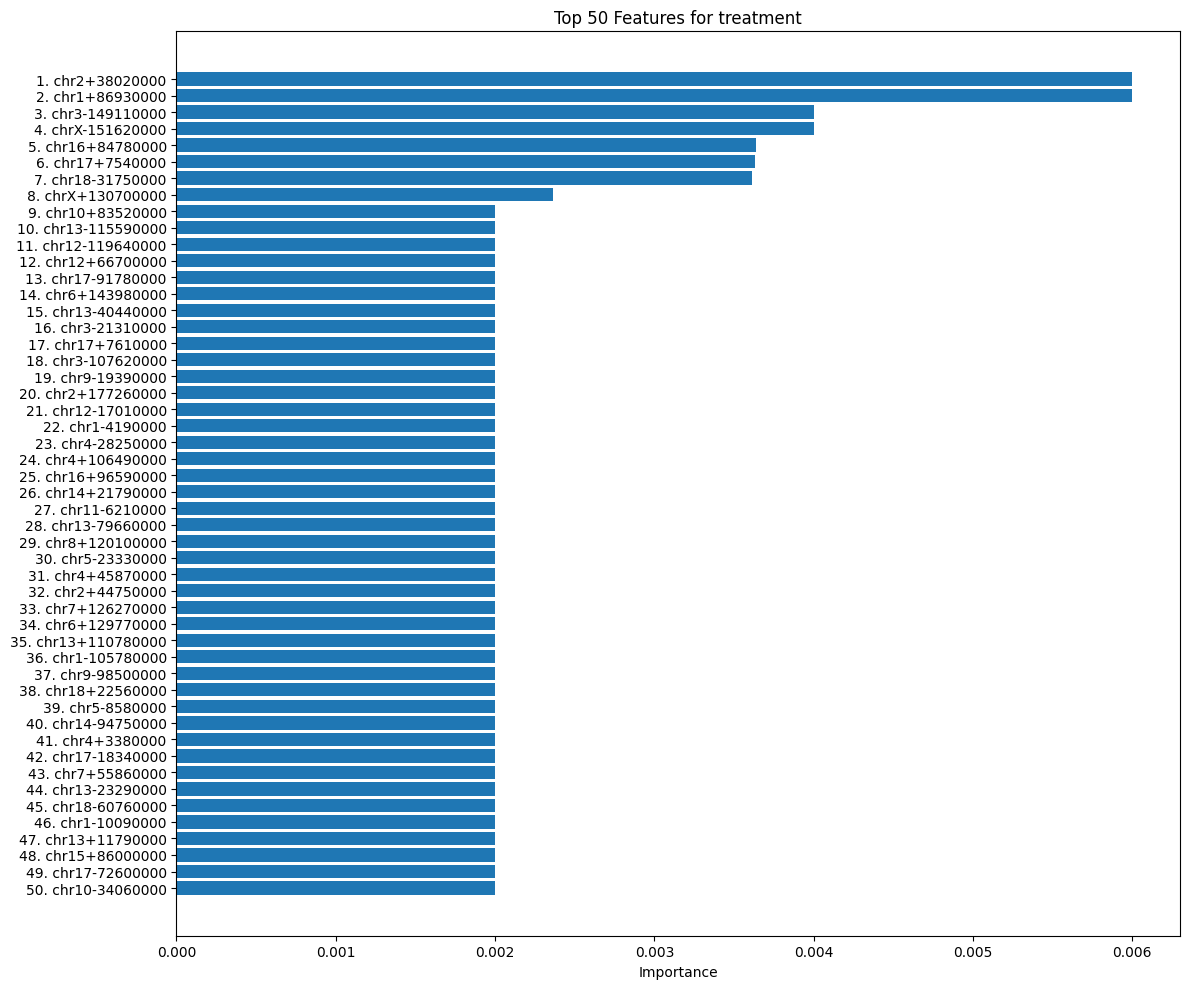

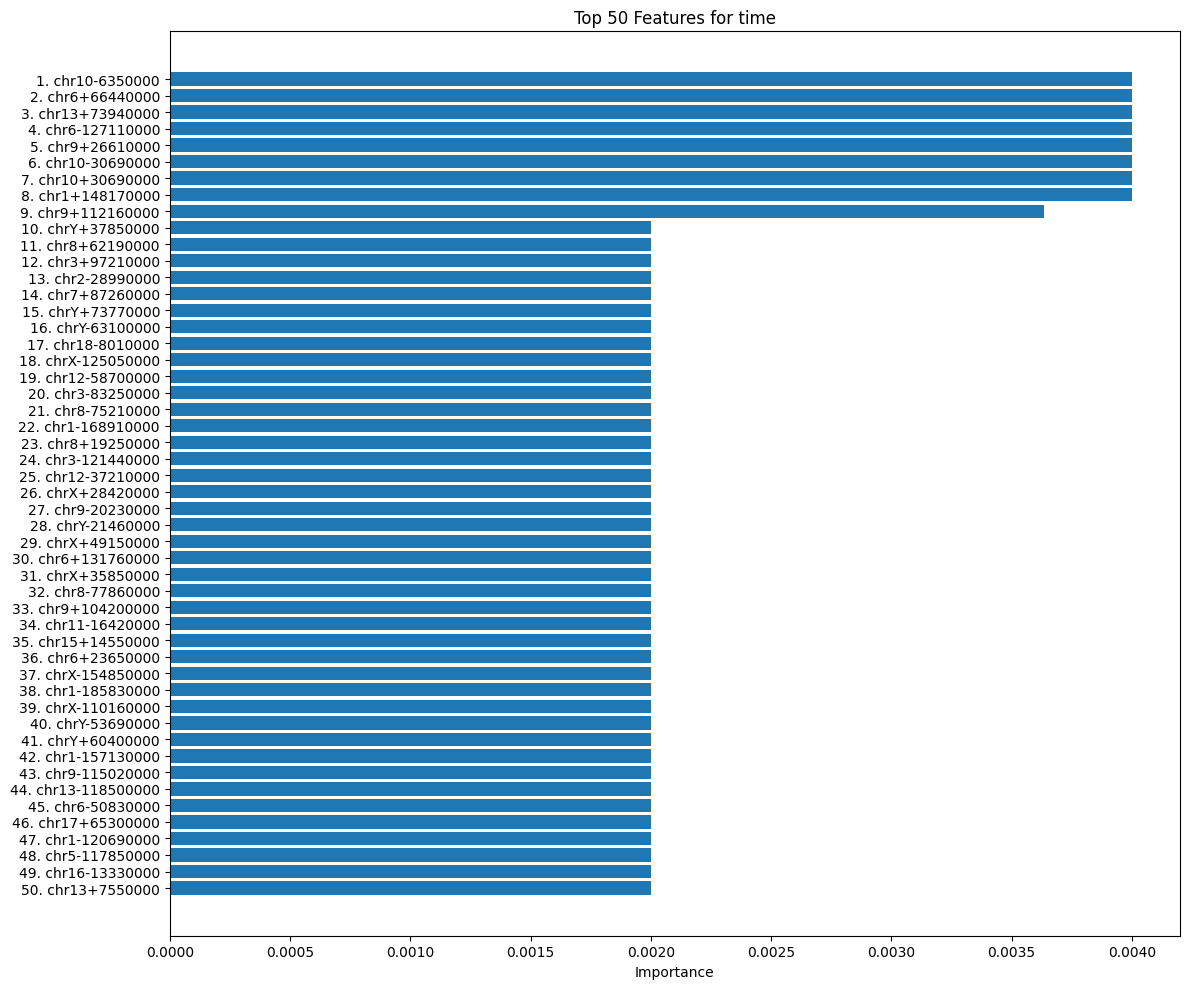

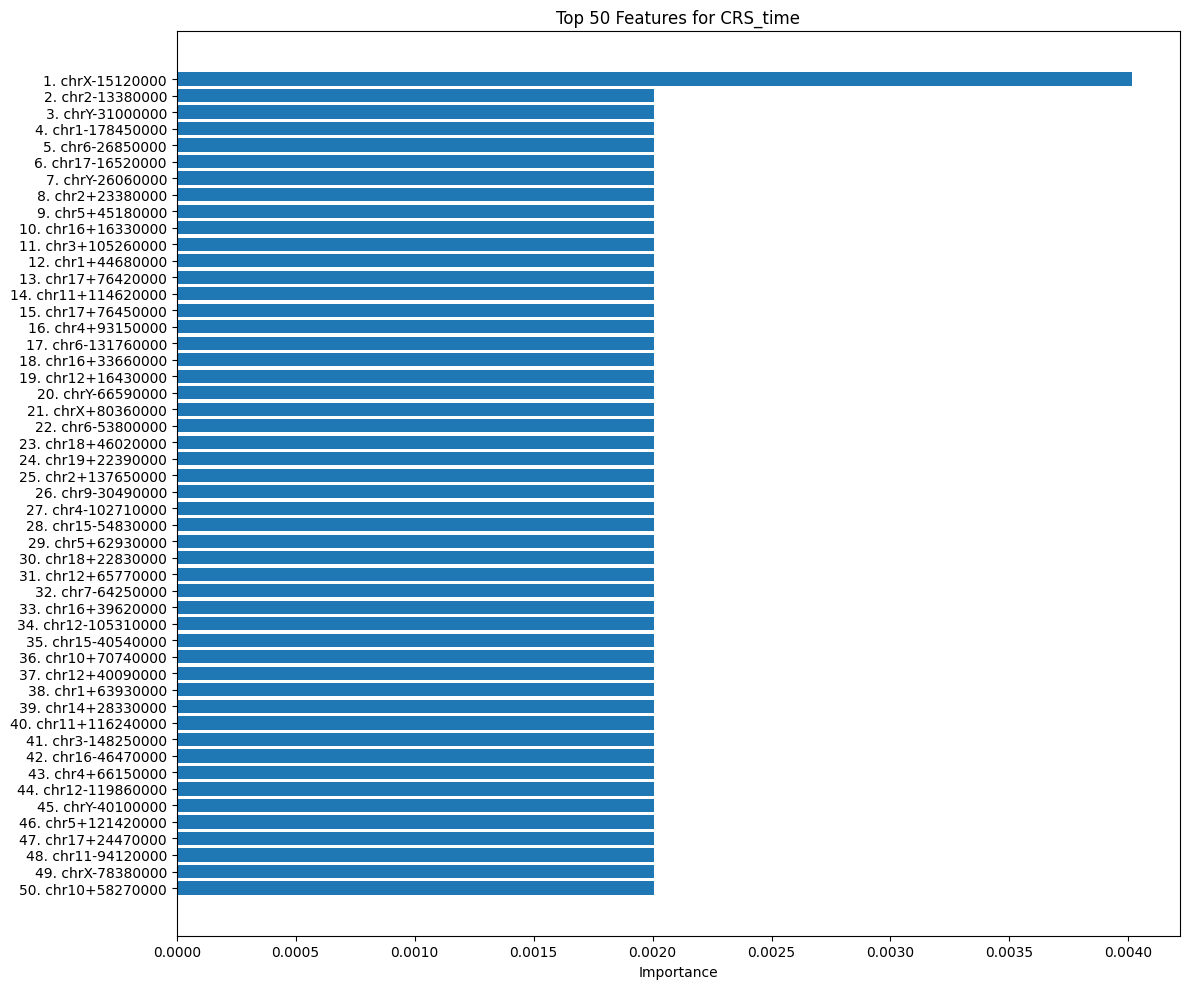

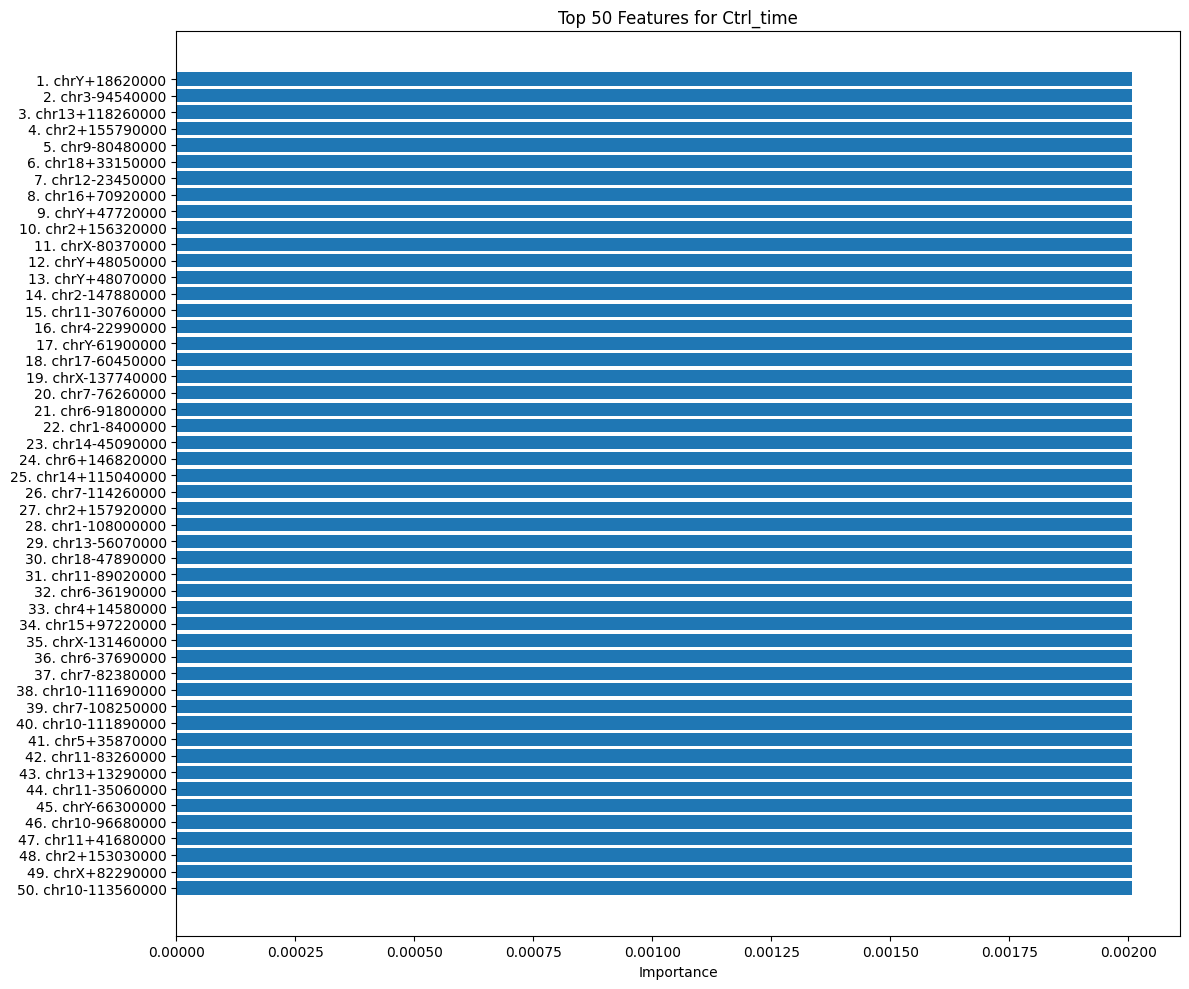

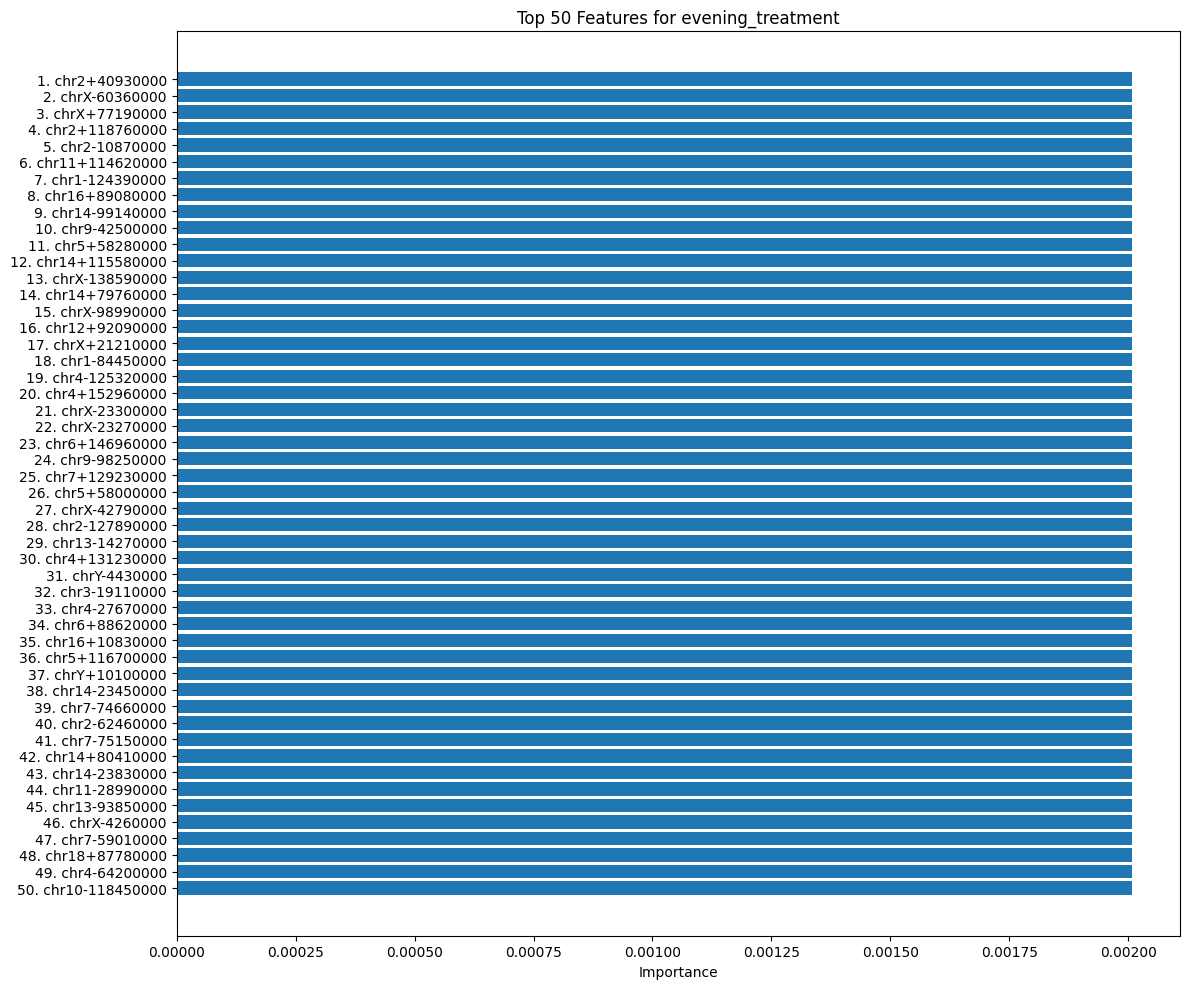

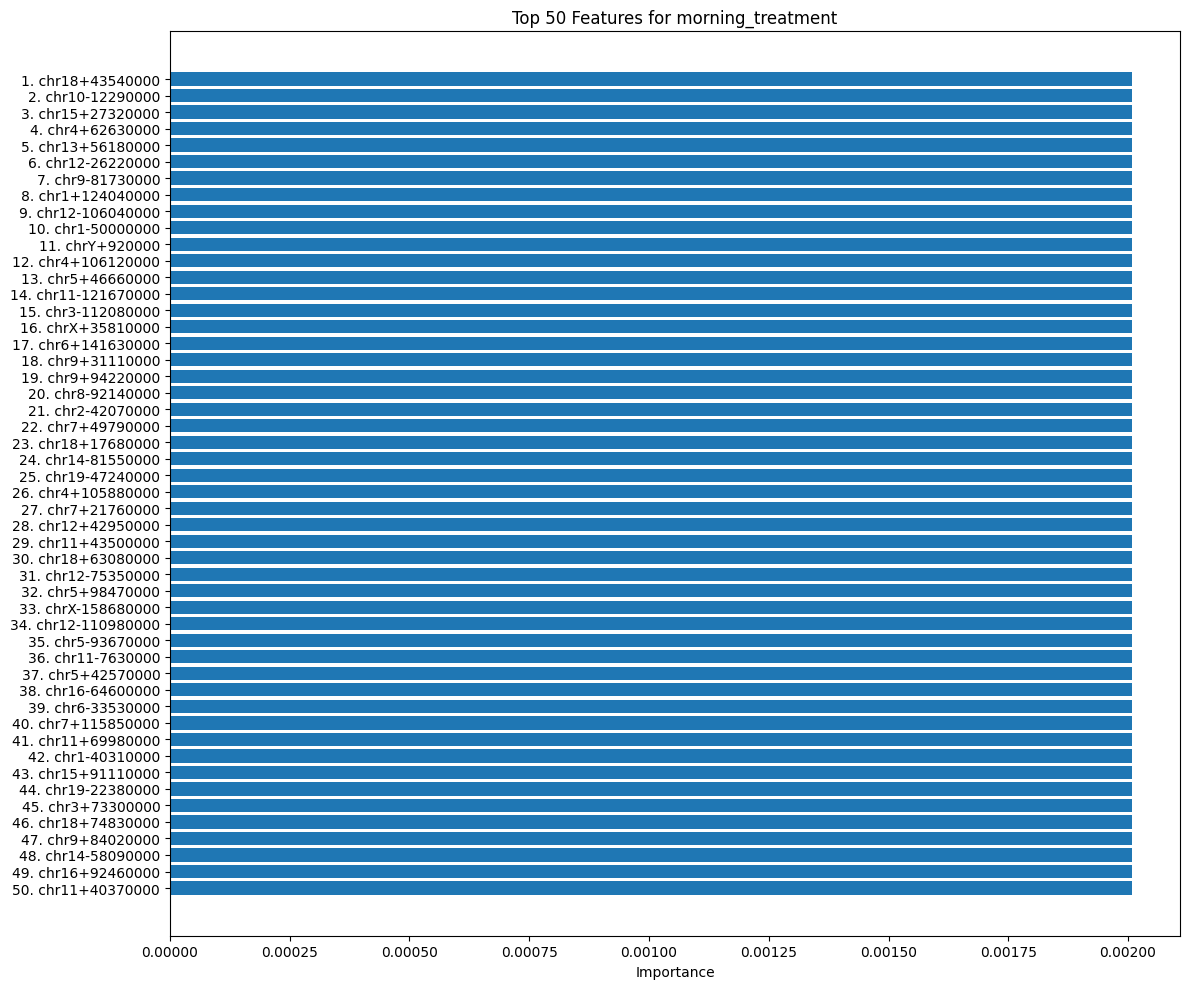

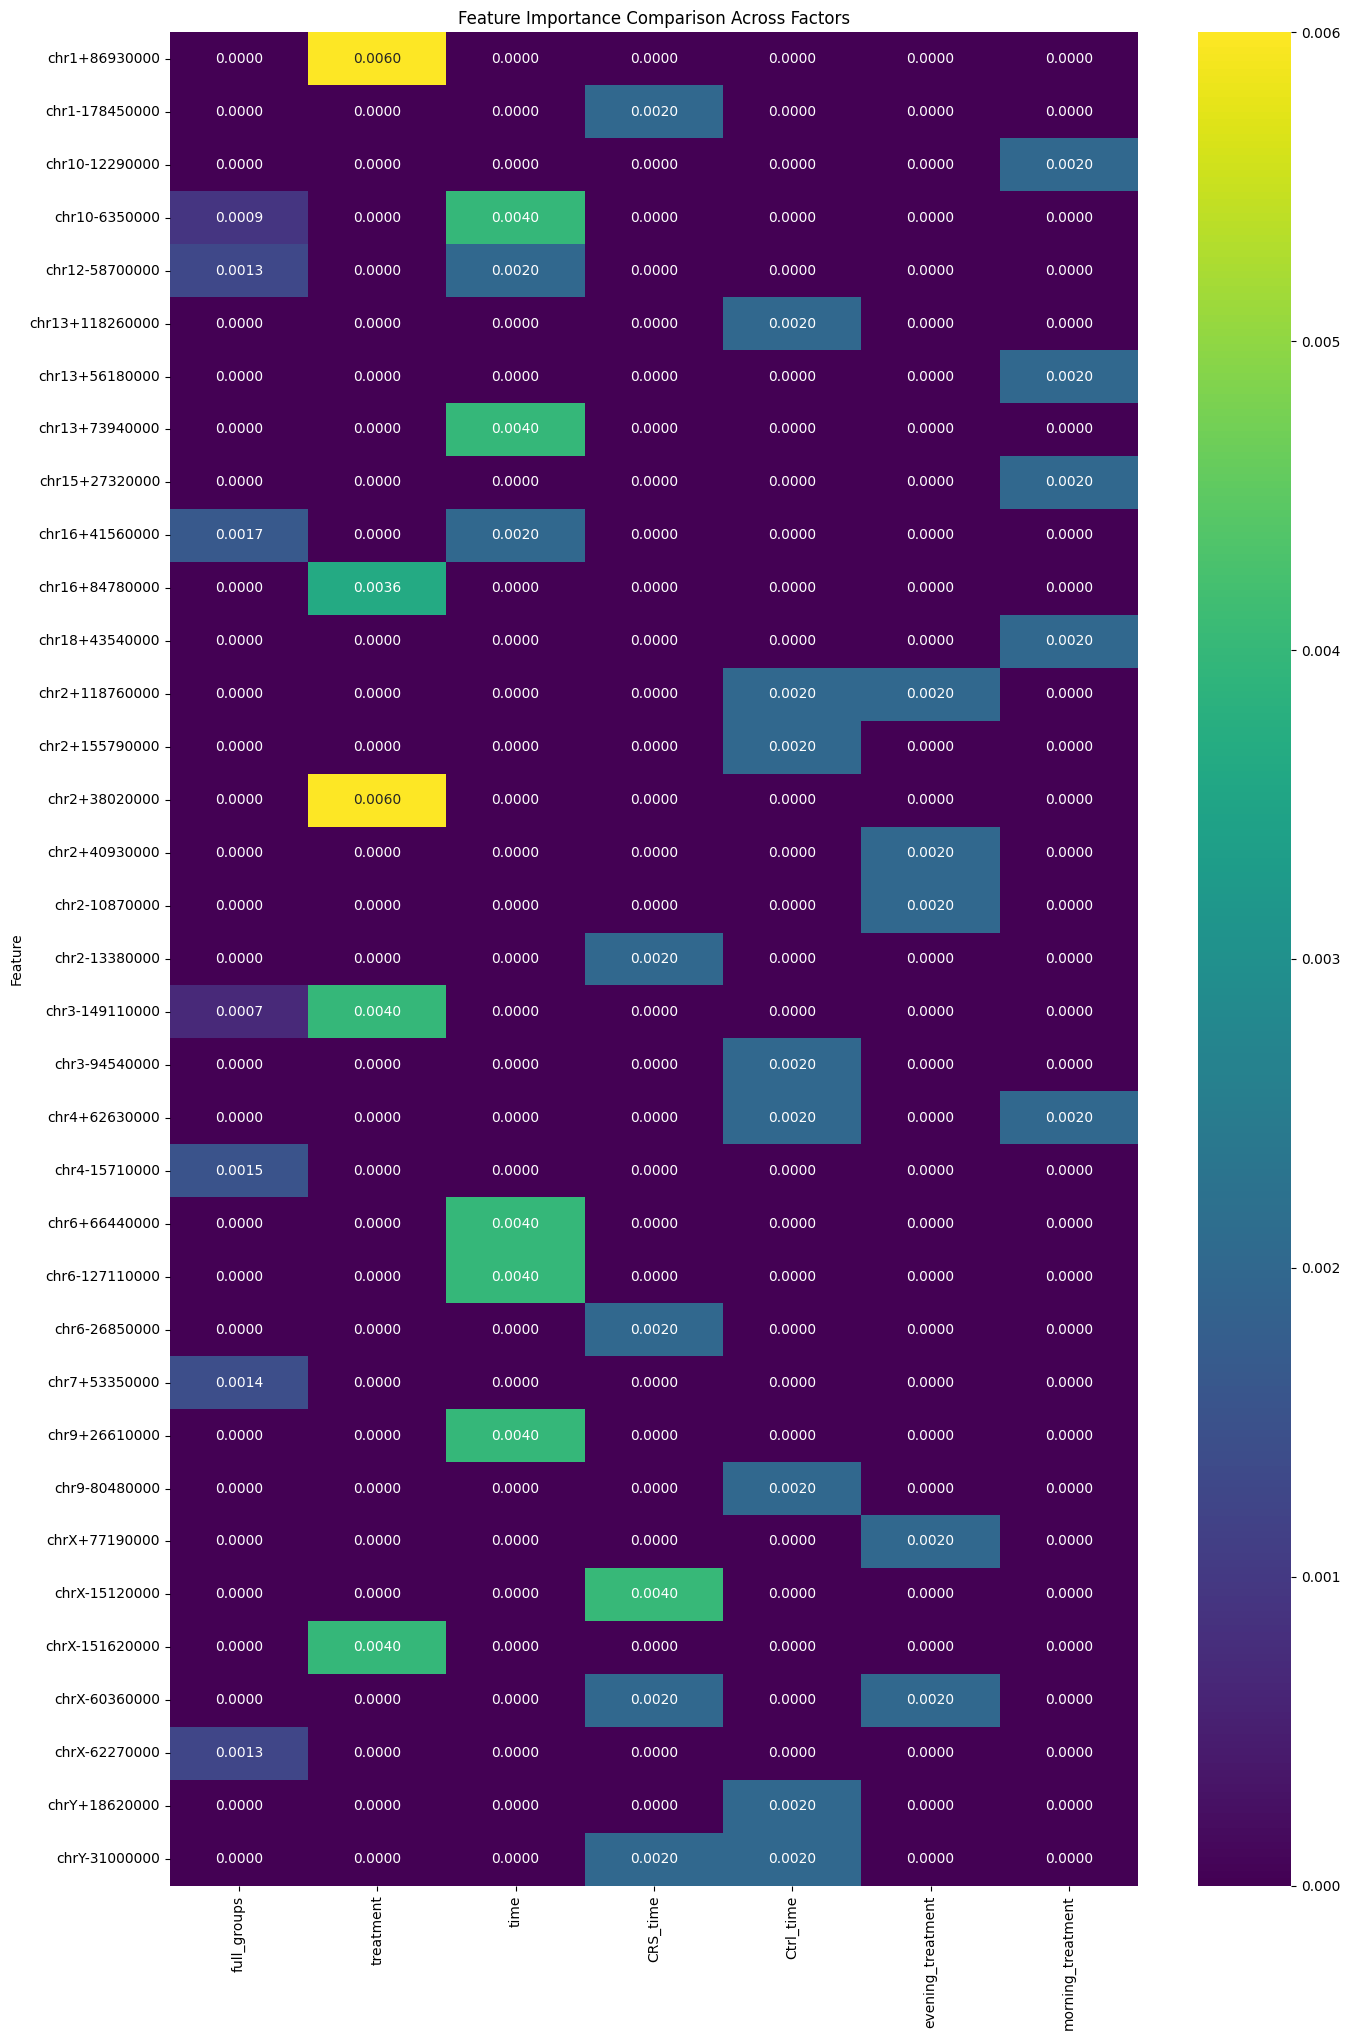

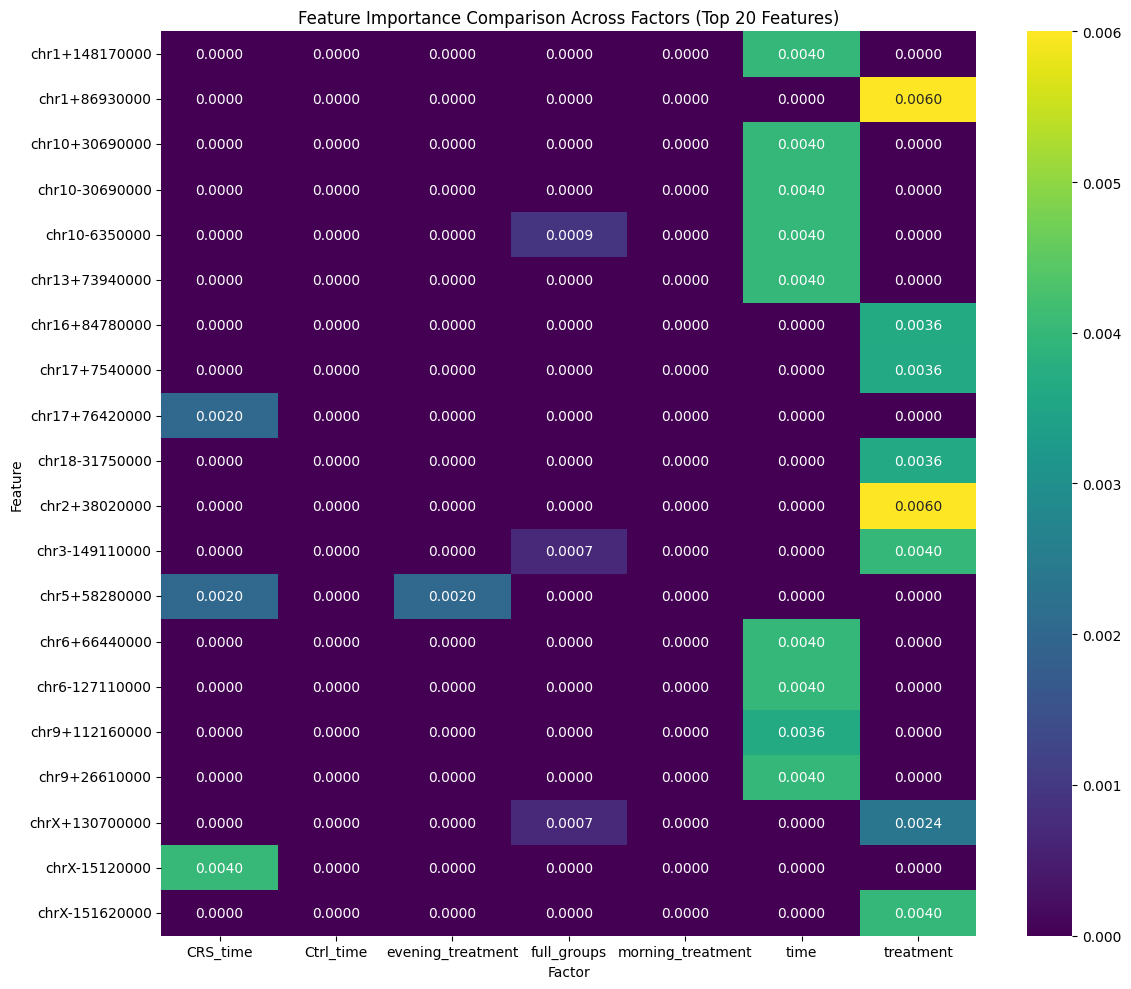

In [12]:
# Run the enhanced analysis
results_dict, importance_dict = run_random_forest_feature_selection_by_factor(
    '../data_normalized/cleaned_Normalized_10000.csv', 
    '../data_rf/bin10000'
)

# Optionally run the additional cross-factor comparison
comparison_df = feature_importance_comparison(
    importance_dict, 
    '../data_rf/bin10000'
)

Reading data from ../data_normalized/cleaned_Normalized_1000.csv...


IOStream.flush timed out



Example UCSC Feature IDs:
  Original: 3049000.0_-NC_000067.7 → UCSC: chr1-3049000
  Original: 3050000.0_+NC_000067.7 → UCSC: chr1+3050000
  Original: 3050000.0_-NC_000067.7 → UCSC: chr1-3050000
  Original: 3051000.0_+NC_000067.7 → UCSC: chr1+3051000
  Original: 3051000.0_-NC_000067.7 → UCSC: chr1-3051000
Data shape: (20, 5300115) (samples × features)

Sample group distribution:
  CRS_evening: 5 samples
  CRS_morning: 5 samples
  Ctrl_evening: 5 samples
  Ctrl_morning: 5 samples

Analyzing factor: full_groups
Classes for full_groups: ['CRS_evening' 'CRS_morning' 'Ctrl_evening' 'Ctrl_morning']
Class distribution: [5, 5, 5, 5]
Training Random Forest for full_groups...
Saved all features with importance metrics for full_groups to ../data_rf/bin1000/full_groups_all_features_importance.csv
Top 10 Features for full_groups:
  1. chr11+117547000: 0.001660
  2. chr10-91913000: 0.001415
  3. chr17-40573000: 0.001290
  4. chr16+70143000: 0.001253
  5. chr1+98968000: 0.001253
  6. chr14+14996000: 

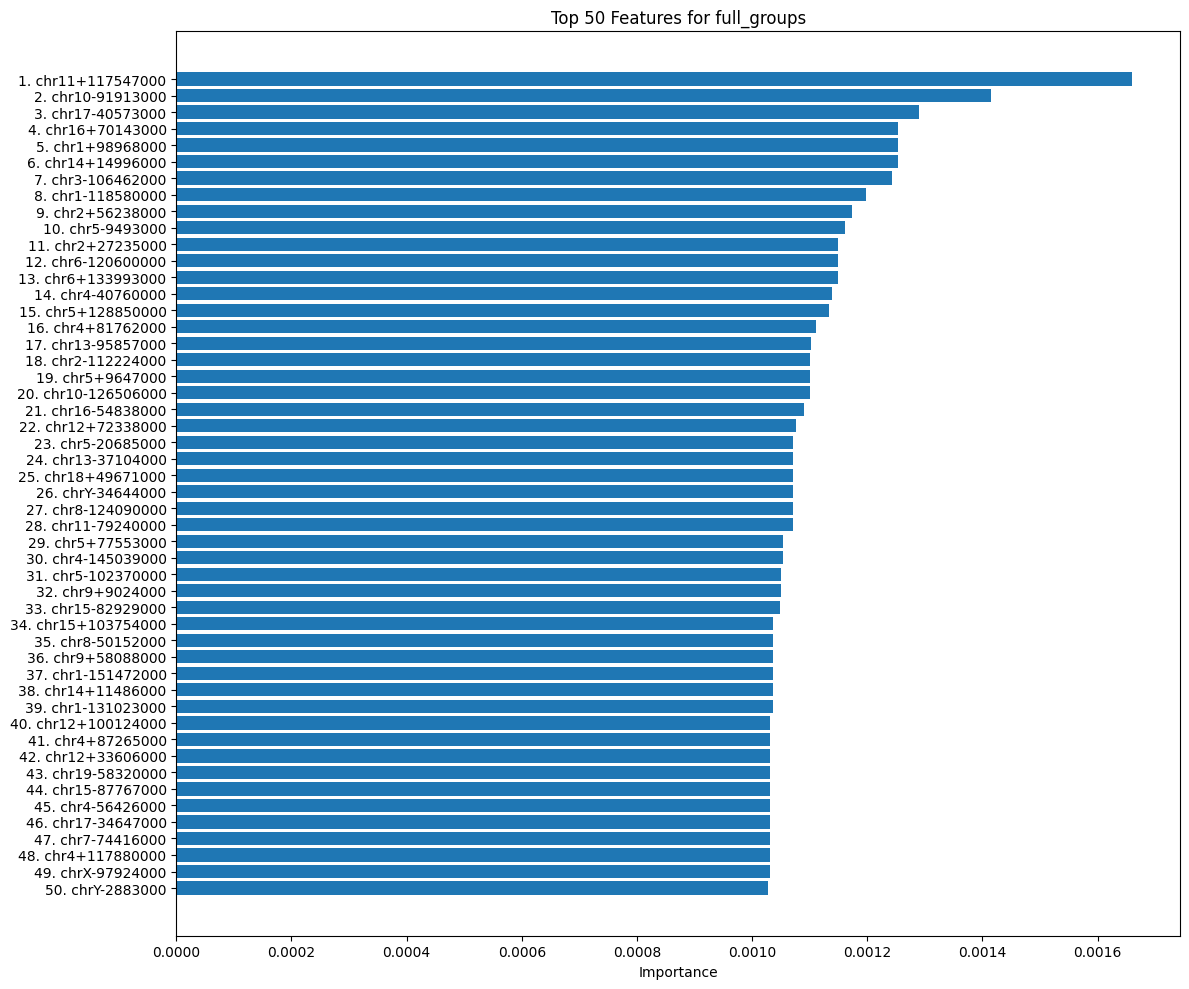

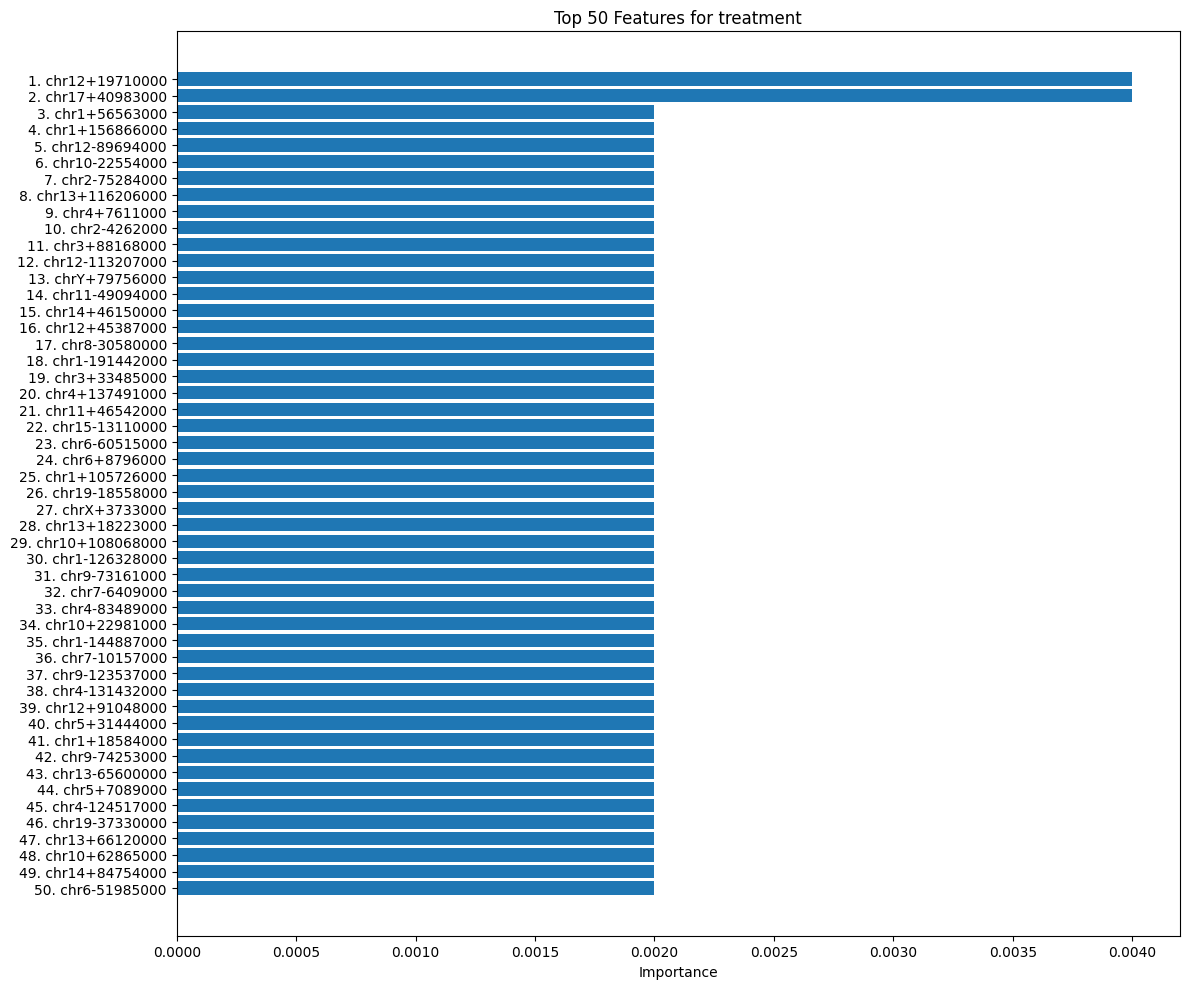

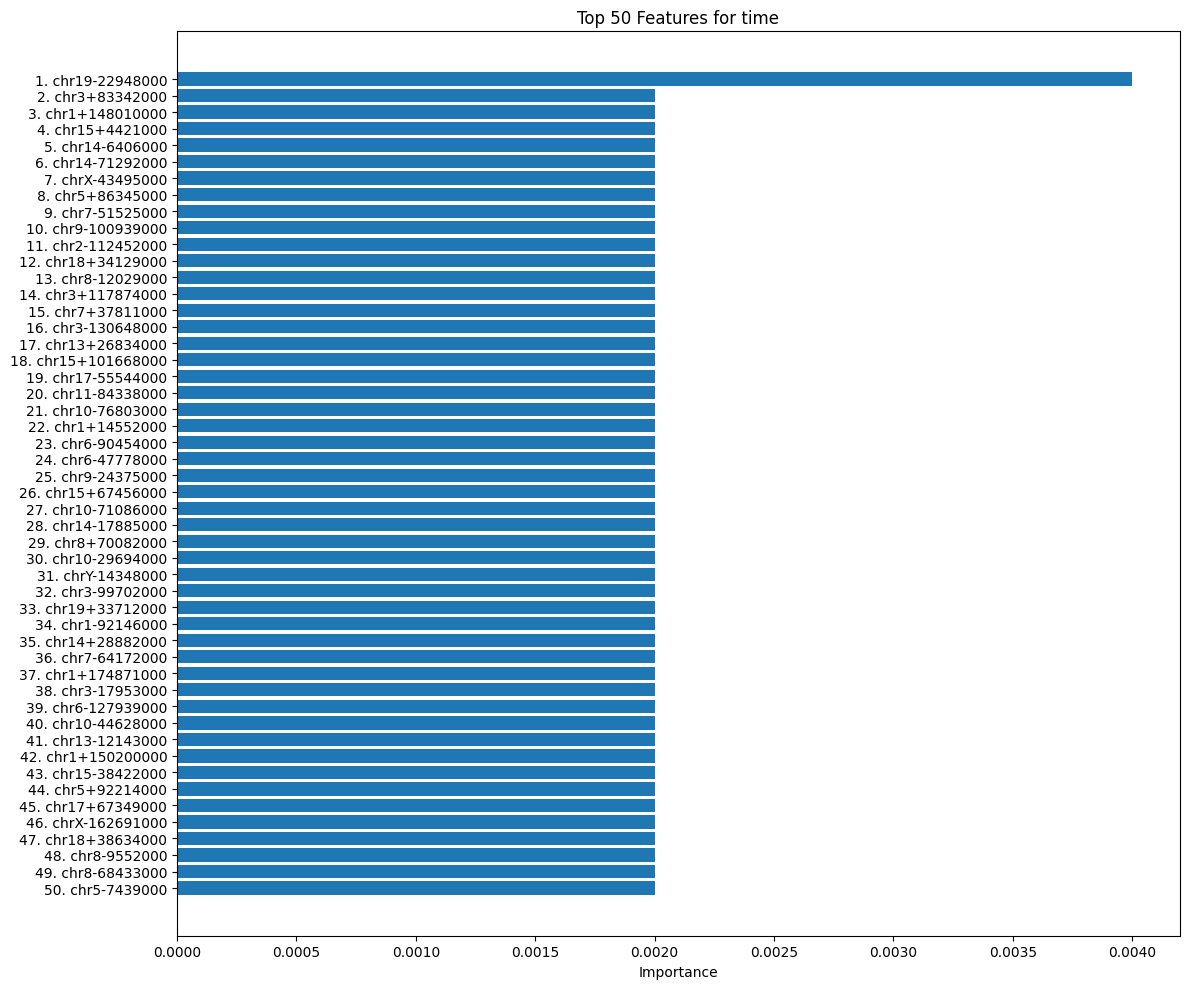

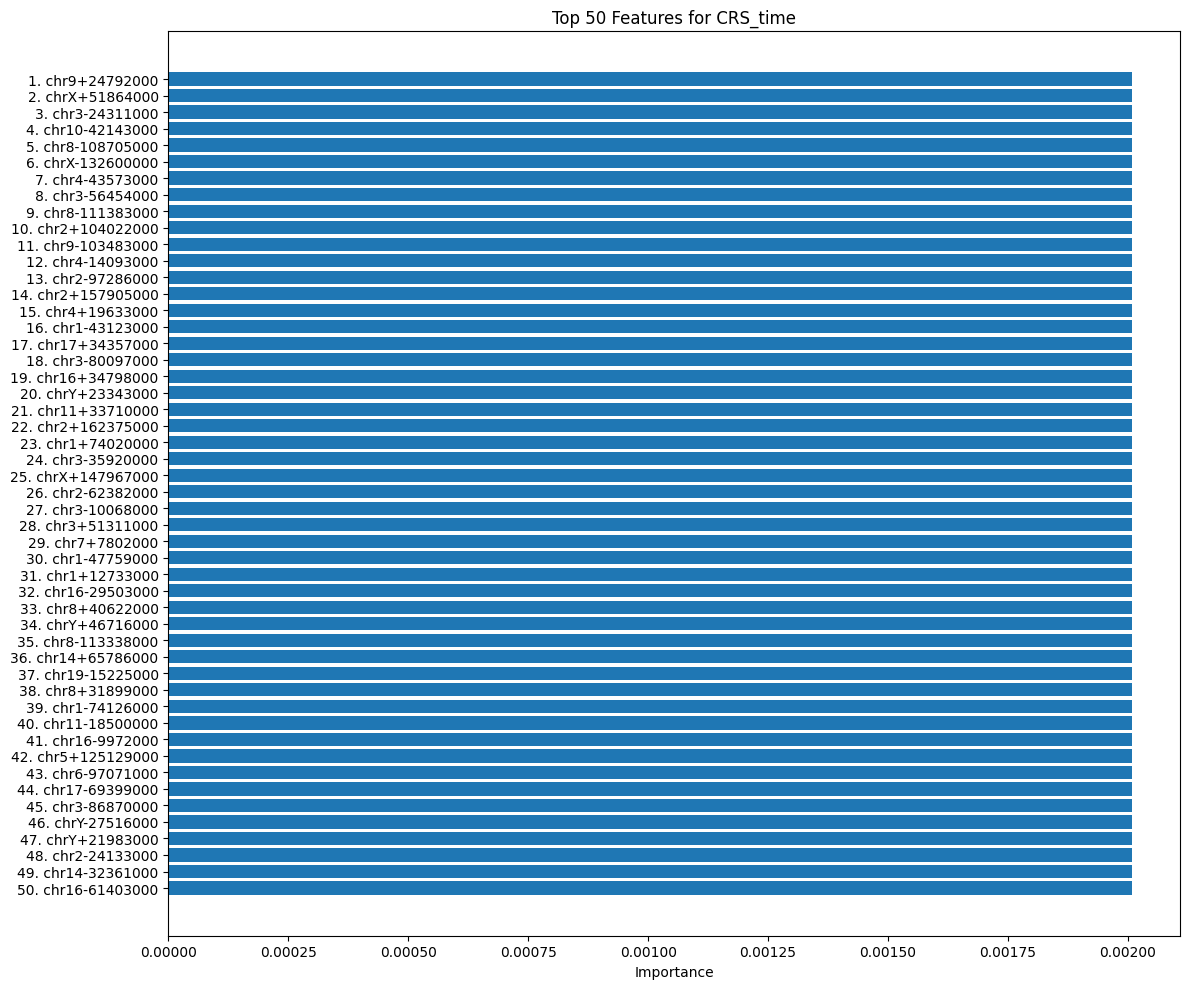

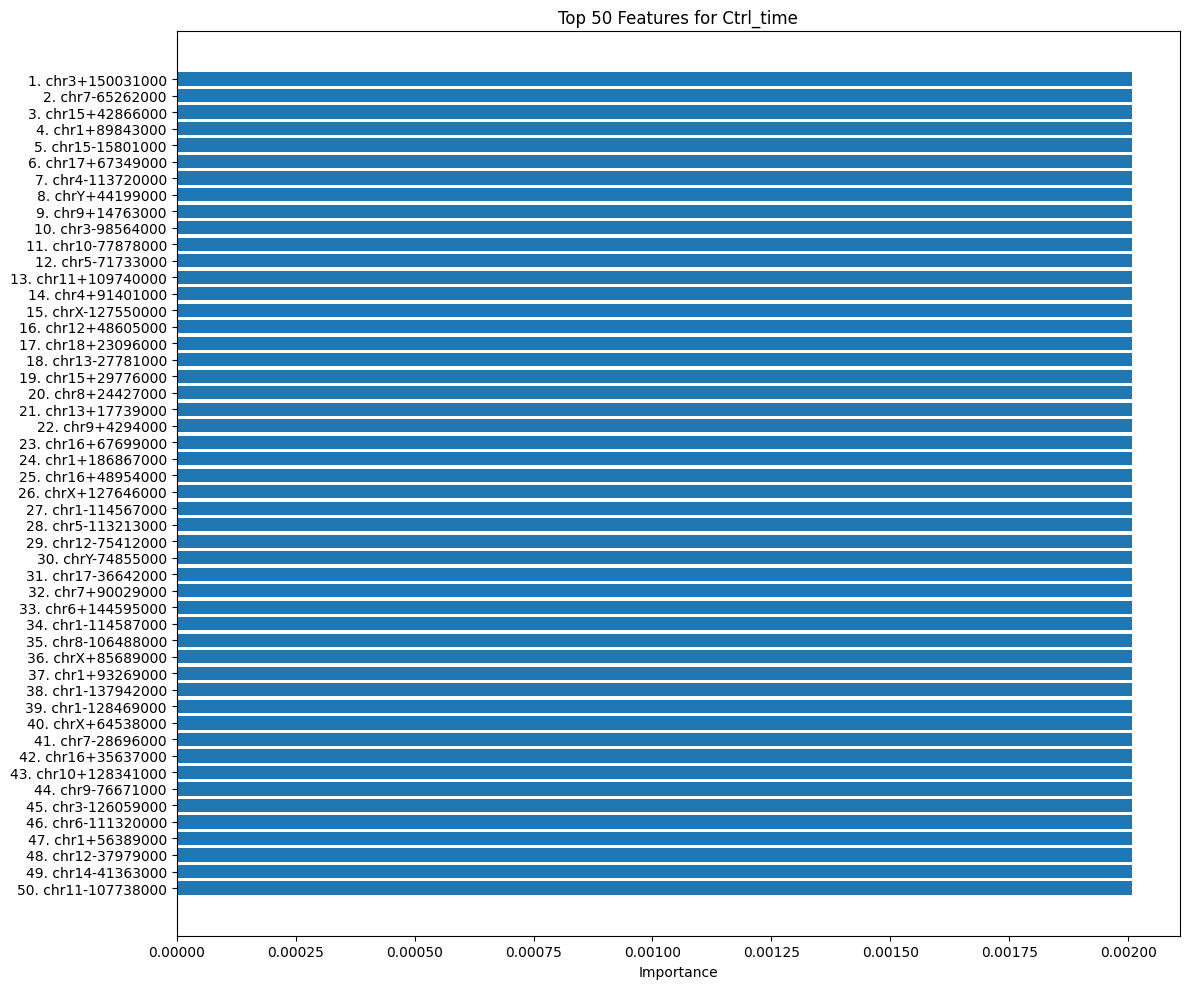

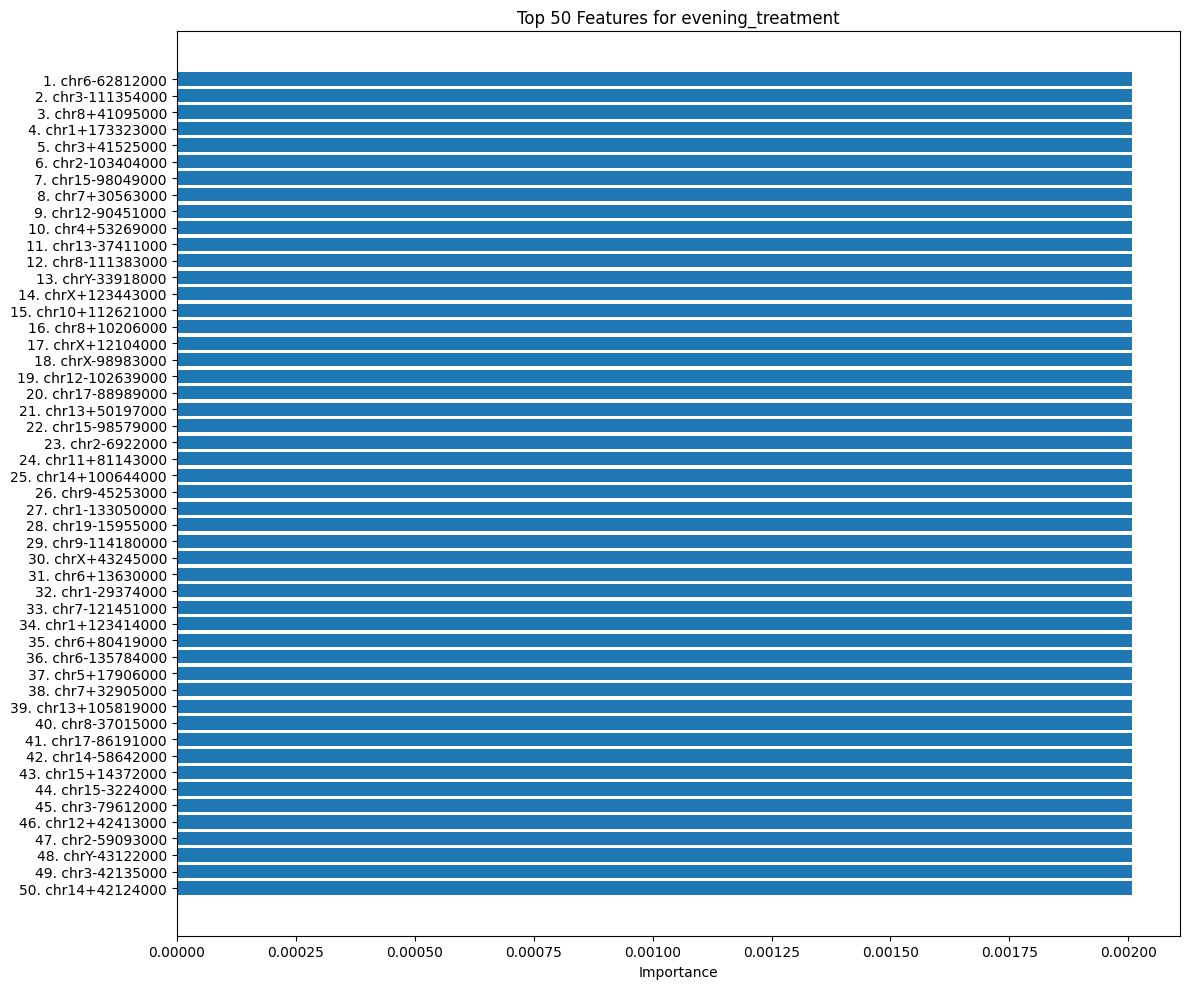

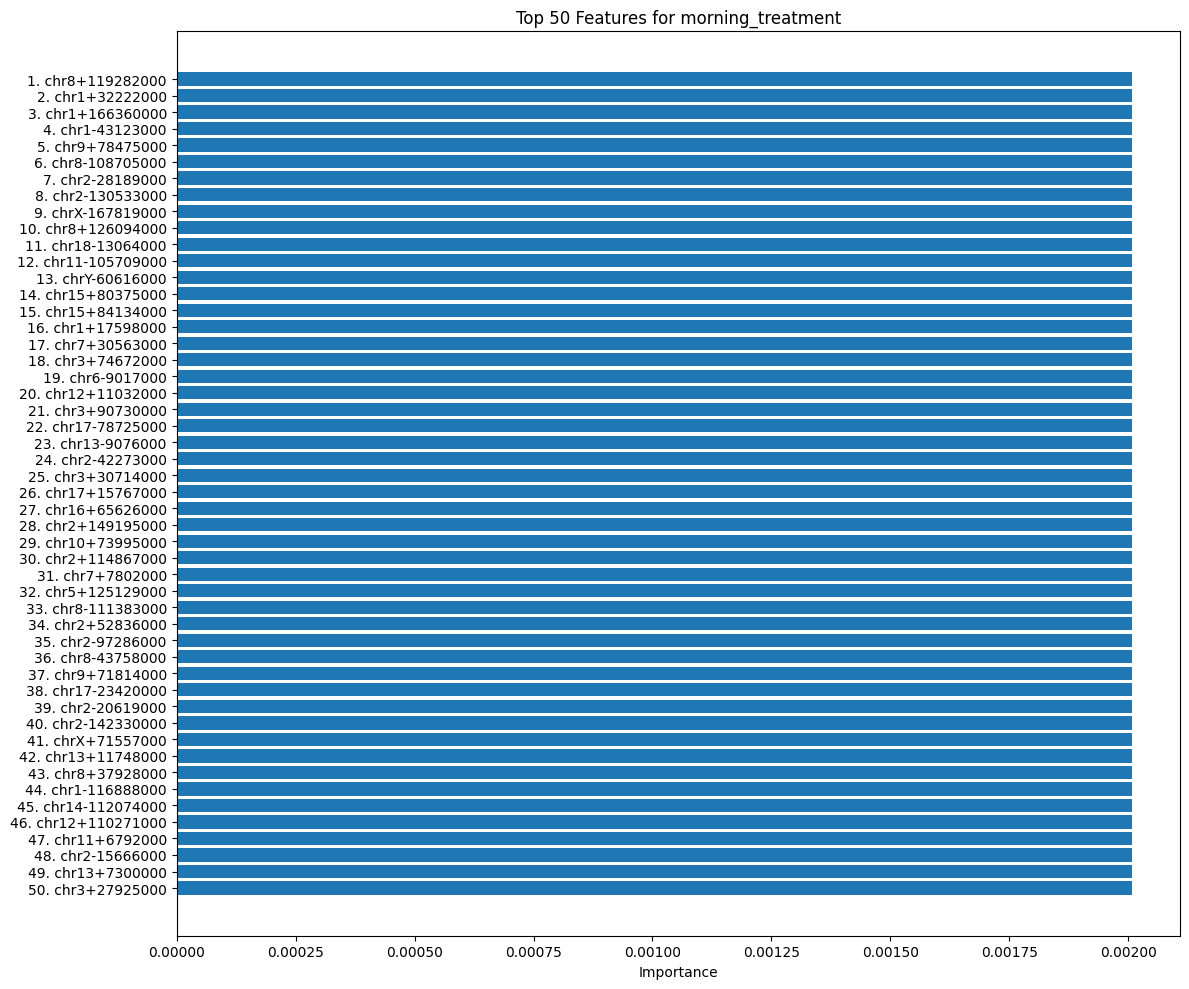

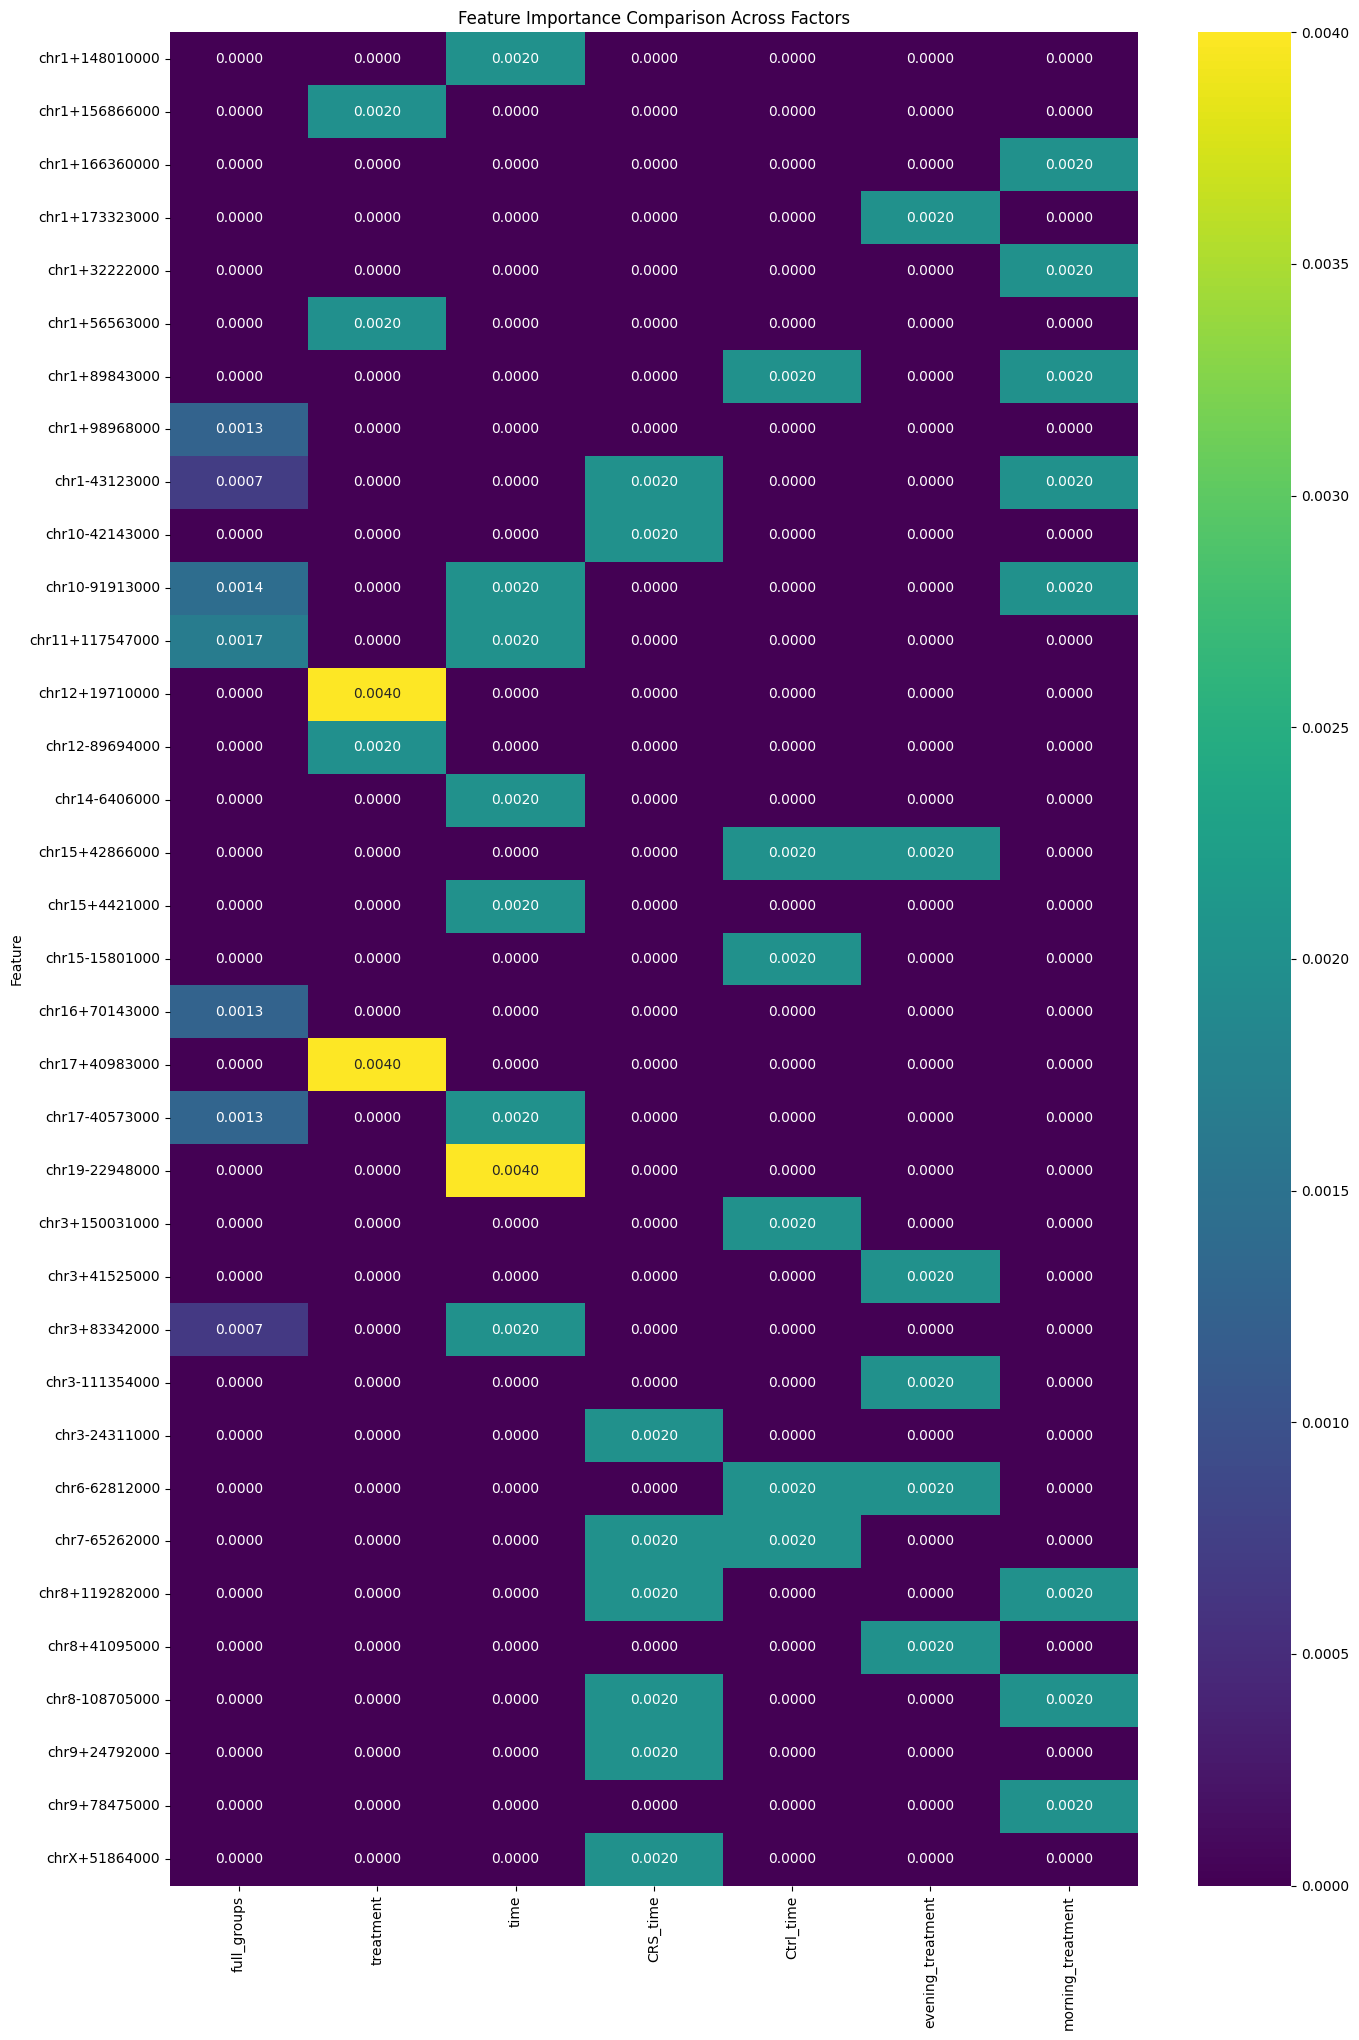

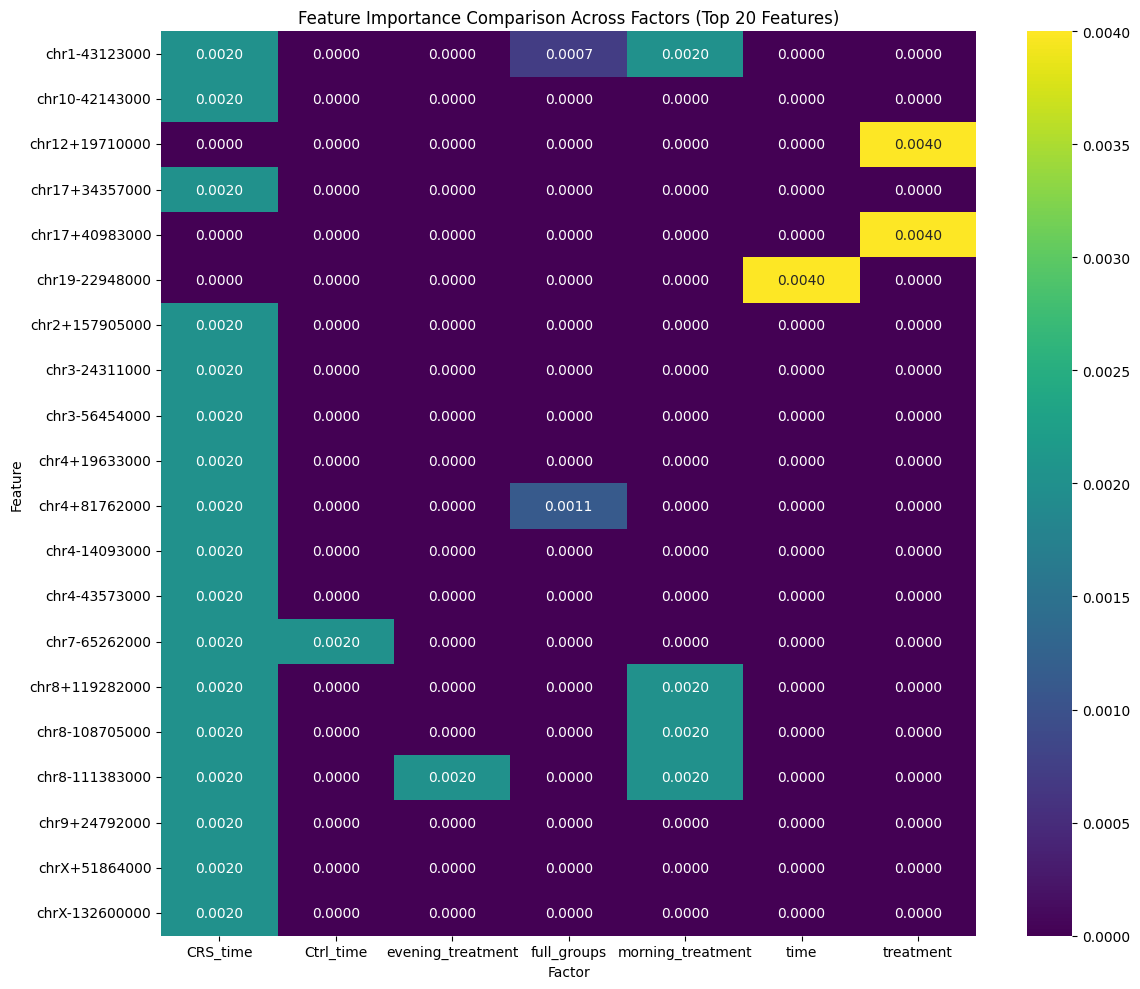

In [14]:
# Run the enhanced analysis
results_dict, importance_dict = run_random_forest_feature_selection_by_factor(
    '../data_normalized/cleaned_Normalized_1000.csv', 
    '../data_rf/bin1000'
)

# Optionally run the additional cross-factor comparison
comparison_df = feature_importance_comparison(
    importance_dict, 
    '../data_rf/bin1000'
)